# Helios AI: Feature Engineering Challenge

## Overview

This notebook implements a comprehensive feature engineering pipeline for the Helios Corn Climate Challenge. The primary goal is to generate climate risk features that predict corn futures prices based on environmental stressors affecting corn-growing regions worldwide.

### Data Integration Modes

The notebook supports two distinct operational modes controlled by the `USE_EXTERNAL_DATA` parameter:

**When `USE_EXTERNAL_DATA = True`:**
- Combines the Helios dataset with external data sources from FRED (Federal Reserve Economic Data) and Open-Meteo weather data
- Enriches climate risk features with macroeconomic indicators (VIX, oil prices, etc.) and high-resolution meteorological variables
- Enables creation of advanced composite features such as GDD (Growing Degree Days) deficits, regional weather rankings, and climate-economy interaction terms
- Optimized feature set includes 78+ engineered features

**When `USE_EXTERNAL_DATA = False`:**
- Uses exclusively the `climate_risk_*` columns from the provided Helios dataset
- Focuses on temporal aggregations, transformations, and stress indicators derived solely from the baseline climate risk data
- Optimized feature set includes 48+ engineered features
- Suitable for scenarios where external data sources are unavailable or when testing baseline performance

Both modes apply sophisticated feature engineering techniques including rolling statistics, exponential moving averages, volatility measures, interaction terms, and non-linear transformations to maximize predictive power measured by the CFCS (Corn Futures Correlation Score).

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Pandas: Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Seaborn
sns.set_theme(style="whitegrid")

# Configuration

**`MIN_SIG_COUNT`** (int, default: 78)
- Minimum threshold for significant feature correlations used in feature selection
- Recommended values: 78 (with external data), 48 (without external data)

**`HIGH_RISK_MULTIPLIER`** (int, default: 2)
- Multiplier applied to high-risk climate events for weighted risk calculations
- Emphasizes the impact of severe climate stress conditions

**`STRESS_THRESHOLDS`** (dict)
- Threshold values for classifying climate stress severity levels (low/medium/high)
- Specific thresholds per climate risk category:
  - `heat_stress`: 0.75
  - `drought`: 0.63
  - `excess_precip`: 0.5
  - `unseasonably_cold`: 0.5

**`LAGS`** (list, default: [7, 14, 30, 60, 90, 270, 365, 400])
- Lag periods (in days) for creating temporal features
- Used for rolling windows, moving averages, and historical comparisons

**`USE_EXTERNAL_DATA`** (bool, default: False)
- Controls data integration mode
- If `True`: Combines Helios data with external FRED and Open-Meteo weather data
- If `False`: Uses only `climate_risk_*` columns from the provided dataset

**`DO_OPTIMIZATION`** (bool, default: False)
- Enables hyperparameter optimization and extensive feature selection
- Warning: May take 0.5-4 hours depending on configuration when enabled

In [2]:
################################
## Settings w/o external data
################################
#MIN_SIG_COUNT = 48 #BEST 
#USE_EXTERNAL_DATA = False # If True --> FRED & Meteo Data will be used


################################
## Settings with external data
################################
MIN_SIG_COUNT = 78 #BEST 
USE_EXTERNAL_DATA = True # If True --> FRED & Meteo Data will be used


DO_OPTIMIZATION = False # If True --> depending on config it will take 0.5-4h

HIGH_RISK_MULTIPLIER = 2

STRESS_THRESHOLDS = {
    'heat_stress': 0.75,
    'drought': 0.63,
    'excess_precip': 0.5,
    'unseasonably_cold': 0.5
}

LAGS = [7, 14, 30, 60, 90, 270, 365, 400]

In [3]:
# Input Data
INPUT_MASTER_FILE = "/kaggle/input/forecasting-the-future-the-helios-corn-climate-challenge/corn_climate_risk_futures_daily_master.csv"
INPUT_MARKET_SHARE_FILE = "/kaggle/input/forecasting-the-future-the-helios-corn-climate-challenge/corn_regional_market_share.csv"
INPUT_FRED_EXTERNAL_DATA = "/kaggle/input/helios-climate-challenge-ext-data-fred-and-meteo/fred_economic_data.csv"
INPUT_METEO_EXTERNAL_DATA = "/kaggle/input/helios-climate-challenge-ext-data-fred-and-meteo/open_meteo_weather_data.csv"

# Constants
RISK_CATEGORIES = ['heat_stress', 'unseasonably_cold', 'excess_precip', 'drought']
REQUIRED_ROWS = 219161

ALL_NEW_FEATURES = [] #Track all created features

# Load Data

## Helios

In [4]:
# Load main dataset
master_df = pd.read_csv(
    INPUT_MASTER_FILE, 
    parse_dates=['date_on']
)

print(f"Master dataset shape: {master_df.shape}")
print(f"Date range: {master_df['date_on'].min()} to {master_df['date_on'].max()}")
print(f"Countries: {master_df['country_name'].nunique()}")
print(f"Regions: {master_df['region_name'].nunique()}")

master_df.head()

Master dataset shape: (320661, 41)
Date range: 2016-01-01 00:00:00 to 2025-12-15 00:00:00
Countries: 11
Regions: 89


,ID,crop_name,country_name,country_code,region_name,region_id,harvest_period,growing_season_year,date_on,climate_risk_cnt_locations_heat_stress_risk_low,climate_risk_cnt_locations_heat_stress_risk_medium,climate_risk_cnt_locations_heat_stress_risk_high,climate_risk_cnt_locations_unseasonably_cold_risk_low,climate_risk_cnt_locations_unseasonably_cold_risk_medium,climate_risk_cnt_locations_unseasonably_cold_risk_high,climate_risk_cnt_locations_excess_precip_risk_low,climate_risk_cnt_locations_excess_precip_risk_medium,climate_risk_cnt_locations_excess_precip_risk_high,climate_risk_cnt_locations_drought_risk_low,climate_risk_cnt_locations_drought_risk_medium,climate_risk_cnt_locations_drought_risk_high,futures_close_ZC_1,futures_close_ZC_2,futures_close_ZW_1,futures_close_ZS_1,futures_zc1_ret_pct,futures_zc1_ret_log,futures_zc_term_spread,futures_zc_term_ratio,futures_zc1_ma_20,futures_zc1_ma_60,futures_zc1_ma_120,futures_zc1_vol_20,futures_zc1_vol_60,futures_zw_zc_spread,futures_zc_zw_ratio,futures_zs_zc_spread,futures_zc_zs_ratio,date_on_year,date_on_month,date_on_year_month
0,8af42722-3f05-4ede-80fc-605e0e2b3b67,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-15,23,0,0,23,0,0,23,0,0,16,7,0,429.00,434.00,477.50,1156.0,-0.017182,-0.017331,5.00,1.011655,414.4125,387.695833,375.014583,0.013520,0.015724,48.50,0.898429,727.00,0.371107,2016,6,2016_06
1,54f4ddc5-e7ab-4bfb-ad6a-5649841af563,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-16,23,0,0,23,0,0,23,0,0,14,9,0,425.25,430.50,472.50,1134.5,-0.008741,-0.008780,5.25,1.012346,415.7000,388.616667,375.512500,0.013799,0.015792,47.25,0.900000,709.25,0.374835,2016,6,2016_06
2,63a41fce-d371-4295-a58a-dc6491664020,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-17,23,0,0,14,1,8,23,0,0,14,8,1,437.75,442.75,481.25,1159.5,0.029394,0.028971,5.00,1.011422,418.0875,389.770833,376.122917,0.013442,0.016145,43.50,0.909610,721.75,0.377533,2016,6,2016_06
3,cddfa440-e0eb-4735-beb1-1aca2afefe53,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-18,23,0,0,20,0,3,23,0,0,15,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,2016_06
4,3eaacfe1-29be-4da9-b5c9-a9457d2d2b83,Corn: Commodity Tracked,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,Harvest,2017,2016-06-19,23,0,0,21,2,0,23,0,0,16,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,2016_06


In [5]:
# Load regional market share data
market_share_df = pd.read_csv(INPUT_MARKET_SHARE_FILE)

print(f"Market share dataset shape: {market_share_df.shape}")
print(f"Countries: {market_share_df['country_name'].nunique()}")
print(f"Regions: {market_share_df['region_name'].nunique()}")

market_share_df.head()

Market share dataset shape: (95, 5)
Countries: 12
Regions: 95


,country_name,country_code,region_name,region_id,percent_country_production
0,Argentina,AR,Buenos Aires,bffad37a-7c60-432f-984a-8ea83a944311,27.0
1,Argentina,AR,Córdoba,154a85ea-1f8c-4fb8-b0d4-ba26087d9ee7,35.0
2,Argentina,AR,Santa Fe,8ab0a622-787a-43cb-b13f-95955bf3dfd8,10.0
3,Argentina,AR,Santiago del Estero,50e23c9b-44b4-4bbd-8a94-a722c289bb4a,9.0
4,Argentina,AR,Entre Ríos,db76c31d-17f5-4980-b5fc-038ca13cf164,12.0


## FRED
The FRED API is the programmatic interface for the Federal Reserve Economic Data (FRED) database, provided by the Federal Reserve Bank of St. Louis.

**Key Features:**

- **Data Access**: Provides programmatic access to over 800,000 economic time series from various national and international sources
- **Free to Use**: Usage is free, requiring only a simple registration for an API key
- **Data Types**: Includes macroeconomic indicators such as GDP, unemployment rates, inflation rates, interest rates, exchange rates, and much more
- **Formats**: Supports various output formats including JSON, XML, and text
- **Easy Integration**: RESTful API design makes integration into various programming languages (Python, R, JavaScript, etc.) straightforward

Documentation and API keys are available at: https://fred.stlouisfed.org/docs/api/fred/

```python
import pandas as pd
from fredapi import Fred

# FRED API key
api_key = "<API-TOKEN>"

# Initialize Fred client
fred = Fred(api_key=api_key)

# Series IDs to fetch
series_ids = {
    'DTWEXBGS': 'dollar_index',
    'DCOILWTICO': 'oil_price',
    'EFFR': 'interest_rate',
    'CPIAUCSL': 'cpi',
    'UNRATE': 'unemployment_rate',
    'MKTGDPCNA646NWDB': 'gdp_china',
    'MKTGDPMXA646NWDB': 'gdp_mexico',
    'INDPRO': 'industrial_production',
    'DHHNGSP': 'natural_gas_price',
    'PCU484121484121': 'trucking_ppi',
    'VIXCLS': 'vix',
    'WPU01': 'ppi_farm_products',
    'PCEPI': 'pce_price_index',
    'BAMLH0A0HYM2': 'high_yield_spread',
    'DGS10': 'treasury_10y_rate',
    'IMPGS': 'us_imports',
    'EXPGS': 'us_exports'
}

# Date range
start_date = '2010-01-01'
end_date = '2026-01-29'

# Fetch data for each series
all_series = []
for series_id, series_name in series_ids.items():
    series = fred.get_series(series_id, start_date, end_date).to_frame(name=series_name)
    all_series.append(series)

# Combine all series into a single DataFrame
df = pd.concat(all_series, axis=1)

# Forward-fill monthly/annual data to daily
ffill_cols = [
    'cpi', 'unemployment_rate', 'gdp_china', 'gdp_mexico', 
    'industrial_production', 'trucking_ppi', 'ppi_farm_products', 
    'pce_price_index', 'us_imports', 'us_exports'
]
df[ffill_cols] = df[ffill_cols].ffill()

# Save to CSV
df.to_csv('full_external_data.csv')

print("External data downloaded and saved to external_data.csv")
```

In [6]:
print("📊 Loading FRED External Data...")

fred_external_df = pd.read_csv(INPUT_FRED_EXTERNAL_DATA)
fred_external_df['date'] = pd.to_datetime(fred_external_df['date'])
fred_external_df.head()

📊 Loading FRED External Data...


,date,dollar_index,oil_price,interest_rate,cpi,unemployment_rate,gdp_china,gdp_mexico,industrial_production,natural_gas_price,trucking_ppi,vix,ppi_farm_products,pce_price_index,high_yield_spread,treasury_10y_rate,us_imports,us_exports
0,2010-01-01,NaN,NaN,NaN,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,NaN,110.8,NaN,142.5,90.136,NaN,NaN,2269.069,1759.877
1,2010-01-04,92.3566,81.52,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.09,110.8,20.04,142.5,90.136,6.34,3.85,2269.069,1759.877
2,2010-01-05,92.2236,81.74,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.19,110.8,19.35,142.5,90.136,6.30,3.77,2269.069,1759.877
3,2010-01-06,92.0941,83.12,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.47,110.8,19.16,142.5,90.136,6.17,3.85,2269.069,1759.877
4,2010-01-07,92.3684,82.60,0.10,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,7.51,110.8,19.06,142.5,90.136,6.03,3.85,2269.069,1759.877


### Shift Data to prevent Data Leakage

In [7]:
print("\n🔄 Applying 1-day lag to FRED data to prevent data leakage...")
print("   Rationale: Macro data is published end-of-day or with delay.")
print("   → We can only use yesterday's macro data to explain today's price.\n")

# Define all FRED columns to shift
fred_raw_columns = [
    'dollar_index',
    'oil_price',
    'vix',
    'cpi',
    'gdp_china',
    'gdp_mexico',
    'industrial_production',
    'interest_rate',
    'unemployment_rate',
    'treasury_10y_rate'
]

# Sort by date
fred_external_df = fred_external_df.sort_values('date')

# Apply lag-1 shift to each column
shift_count = 0
for col in fred_raw_columns:
    if col in fred_external_df.columns:
        fred_external_df[col] = fred_external_df[col].shift(1)
        shift_count += 1

print(f"✅ Successfully shifted {shift_count} FRED columns by 1 day")
print(f"   First day will have NaN (no previous data) - will be filled below\n")
fred_external_df.head()


🔄 Applying 1-day lag to FRED data to prevent data leakage...
   Rationale: Macro data is published end-of-day or with delay.
   → We can only use yesterday's macro data to explain today's price.

✅ Successfully shifted 10 FRED columns by 1 day
   First day will have NaN (no previous data) - will be filled below



,date,dollar_index,oil_price,interest_rate,cpi,unemployment_rate,gdp_china,gdp_mexico,industrial_production,natural_gas_price,trucking_ppi,vix,ppi_farm_products,pce_price_index,high_yield_spread,treasury_10y_rate,us_imports,us_exports
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.8,NaN,142.5,90.136,NaN,NaN,2269.069,1759.877
1,2010-01-04,NaN,NaN,NaN,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.09,110.8,NaN,142.5,90.136,6.34,NaN,2269.069,1759.877
2,2010-01-05,92.3566,81.52,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.19,110.8,20.04,142.5,90.136,6.30,3.85,2269.069,1759.877
3,2010-01-06,92.2236,81.74,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.47,110.8,19.35,142.5,90.136,6.17,3.77,2269.069,1759.877
4,2010-01-07,92.0941,83.12,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,7.51,110.8,19.16,142.5,90.136,6.03,3.85,2269.069,1759.877


### NaN Filling Strategy
Fills missing FRED economic data using forward-fill → backfill → median.
 - Continuous variables (indices, prices): Assumes values persist across days
 - Discrete variables (rates): Assumes monthly updates, use previous value
 
 Creates new "_filled" columns grouped by region to maintain independence.

In [8]:
print("🔄 Filling NaN values in FRED data...")

# Forward-fill for continuous time series (e.g., indices, prices)
# Rationale: An index often remains constant for several days
fred_continuous = ['dollar_index', 'oil_price', 'vix', 'cpi', 
                   'gdp_china', 'gdp_mexico', 'industrial_production']

filled_count = 0
for col in fred_continuous:
    if col in fred_external_df.columns:
        # Create filled version
        fred_external_df[f'{col}_filled'] = fred_external_df[col].ffill()
        fred_external_df[f'{col}_filled'] = fred_external_df[f'{col}_filled'].bfill()
        fred_external_df[f'{col}_filled'] = fred_external_df[f'{col}_filled'].fillna(fred_external_df[col].median())
        filled_count += 1

# For discrete values (interest rates, unemployment): Use previous value
fred_discrete = ['interest_rate', 'unemployment_rate', 'treasury_10y_rate']

for col in fred_discrete:
    if col in fred_external_df.columns:
        fred_external_df[f'{col}_filled'] = fred_external_df[col].ffill()
        fred_external_df[f'{col}_filled'] = fred_external_df[f'{col}_filled'].bfill()
        fred_external_df[f'{col}_filled'] = fred_external_df[f'{col}_filled'].fillna(fred_external_df[col].median())
        filled_count += 1

print(f"✅ Successfully filled {filled_count} FRED columns")
print(f"   All NaN values handled (ffill → bfill → median)\n")
fred_external_df.head()

🔄 Filling NaN values in FRED data...
✅ Successfully filled 10 FRED columns
   All NaN values handled (ffill → bfill → median)



,date,dollar_index,oil_price,interest_rate,cpi,unemployment_rate,gdp_china,gdp_mexico,industrial_production,natural_gas_price,trucking_ppi,vix,ppi_farm_products,pce_price_index,high_yield_spread,treasury_10y_rate,us_imports,us_exports,dollar_index_filled,oil_price_filled,vix_filled,cpi_filled,gdp_china_filled,gdp_mexico_filled,industrial_production_filled,interest_rate_filled,unemployment_rate_filled,treasury_10y_rate_filled
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.8,NaN,142.5,90.136,NaN,NaN,2269.069,1759.877,92.3566,81.52,20.04,217.488,6.192565e+12,1.105424e+12,89.3426,0.12,9.8,3.85
1,2010-01-04,NaN,NaN,NaN,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.09,110.8,NaN,142.5,90.136,6.34,NaN,2269.069,1759.877,92.3566,81.52,20.04,217.488,6.192565e+12,1.105424e+12,89.3426,0.12,9.8,3.85
2,2010-01-05,92.3566,81.52,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.19,110.8,20.04,142.5,90.136,6.30,3.85,2269.069,1759.877,92.3566,81.52,20.04,217.488,6.192565e+12,1.105424e+12,89.3426,0.12,9.8,3.85
3,2010-01-06,92.2236,81.74,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,6.47,110.8,19.35,142.5,90.136,6.17,3.77,2269.069,1759.877,92.2236,81.74,19.35,217.488,6.192565e+12,1.105424e+12,89.3426,0.12,9.8,3.77
4,2010-01-07,92.0941,83.12,0.12,217.488,9.8,6.192565e+12,1.105424e+12,89.3426,7.51,110.8,19.16,142.5,90.136,6.03,3.85,2269.069,1759.877,92.0941,83.12,19.16,217.488,6.192565e+12,1.105424e+12,89.3426,0.12,9.8,3.85


## Open-Meteo Weather Data
The Open-Meteo API is a free, open-source weather API that provides access to global weather forecasts, historical weather data, and climate information without requiring an API key.

**Key Features:**

- **No API Key Required**: Completely free to use for non-commercial purposes without registration
- **Comprehensive Weather Data**: Offers current weather, hourly forecasts up to 16 days, historical data dating back to 1940, and climate projections
- **Global Coverage**: Provides weather data for any location worldwide with high spatial resolution
- **Data Types**: Includes temperature, precipitation, wind speed/direction, humidity, pressure, cloud cover, solar radiation, and various weather codes
- **Multiple Weather Models**: Integrates data from leading weather services including NOAA, DWD, MeteoFrance, and ECMWF
- **Formats**: Returns data in JSON format with clean, well-structured responses
- **Easy Integration**: Simple REST API design with straightforward query parameters, ideal for integration into web applications, mobile apps, and data analysis tools
- **Performance**: Fast response times with efficient caching and CDN delivery

Documentation and usage examples are available at: https://open-meteo.com/en/docs

```python

import requests
import pandas as pd
import io
import time
import os

# https://open-meteo.com/en/docs
# https://open-meteo.com/en/docs/historical-weather-api

def get_weather_data(output_file="open_meteo_weather_data.csv", failed_file="open_meteo_failed_regions.csv"):
    # Read the region coordinates data
    coordinates_df = pd.read_csv('region_coordinates.csv')
    
    # Construct the query
    daily_params = [
        "temperature_2m_max", "temperature_2m_min", 
        "soil_moisture_0_to_7cm_mean", "soil_moisture_7_to_28cm_mean", 
        "soil_temperature_0_to_7cm_mean", "soil_temperature_7_to_28cm_mean", 
        "et0_fao_evapotranspiration_sum",
        "precipitation_sum",
        "shortwave_radiation_sum", 
        "weather_code",
    ]

    # --- Resume Logic ---
    if os.path.exists(output_file):
        existing_data = pd.read_csv(output_file)
        # Create a set of already fetched regions for faster lookup
        fetched_regions = set(existing_data['region'])
        # Filter coordinates_df to only include regions that have not been fetched
        coordinates_df = coordinates_df[~coordinates_df['region'].isin(fetched_regions)]
        print(f"Resuming download. {len(fetched_regions)} regions already fetched.")
    else:
        # Write header to CSV file if it doesn't exist
        header_df = pd.DataFrame(columns=daily_params + ['country', 'region'])
        header_df.to_csv(output_file, index=False)
        
    if os.path.exists(failed_file):
        # If we are resuming, we should retry the failed regions as well
        failed_regions_df = pd.read_csv(failed_file, names=['country', 'region'])
        # Get the regions to retry
        regions_to_retry = failed_regions_df['region'].unique()
        # Filter the coordinates_df to only include the failed regions
        coordinates_df = coordinates_df[coordinates_df['region'].isin(regions_to_retry)]
        print(f"Retrying {len(coordinates_df)} failed regions.")
        # Clean up the failed_regions.csv before the new run
        os.remove(failed_file)

    # Historical Weather API URL
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    # Iterate over the regions and get the weather data
    for index, row in coordinates_df.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        country = row['country']
        region = row['region']
        
        params = {
            'latitude': latitude,
            'longitude': longitude,
            'start_date': '2010-01-01',
            'end_date': '2014-12-31',
            'daily': daily_params,
            'timezone': 'UTC'
        }
        
        # Make the API request
        try:
            response = requests.get(url, params=params)
            response.raise_for_status() # Raise an exception for bad status codes
            
            data = response.json()
            daily_data = data['daily']
            # Create a dataframe with the weather data
            temp_df = pd.DataFrame(daily_data)
            #### MISSING: first col is named time
            temp_df['country'] = country
            temp_df['region'] = region
            
            # Append the data to the CSV file
            temp_df.to_csv(output_file, mode='a', header=False, index=False)
            print(f"Got weather data for {region}, {country}")

        except requests.exceptions.RequestException as e:
            print(f"Error getting weather data for {region}, {country}: {e}")
            # Log failed region to a file
            with open(failed_file, 'a') as f:
                f.write(f"{country},{region}\n")

        # Add a delay to avoid rate limiting
        time.sleep(20)

    print(f"Successfully wrote to {output_file}")

if __name__ == '__main__':
    get_weather_data()

```

In [9]:
meteo_df = pd.read_csv(INPUT_METEO_EXTERNAL_DATA)
meteo_df['date'] = pd.to_datetime(meteo_df['date'])
meteo_df.head()

,date,temperature_2m_max,temperature_2m_min,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_temperature_0_to_7cm_mean,soil_temperature_7_to_28cm_mean,et0_fao_evapotranspiration_sum,precipitation_sum,shortwave_radiation_sum,weather_code,country,region
0,2010-01-01,24.4,18.8,0.344,0.413,22.7,22.6,4.98,0.6,21.50,51,Argentina,Buenos Aires
1,2010-01-02,27.8,19.2,0.331,0.402,24.7,23.1,5.77,0.0,29.70,1,Argentina,Buenos Aires
2,2010-01-03,28.6,21.8,0.304,0.392,25.5,24.3,5.53,0.0,25.81,3,Argentina,Buenos Aires
3,2010-01-04,26.0,21.3,0.393,0.392,24.2,24.4,2.54,20.3,9.36,63,Argentina,Buenos Aires
4,2010-01-05,29.0,21.3,0.424,0.410,25.7,24.1,4.80,0.0,25.25,3,Argentina,Buenos Aires


### Shift Data to prevent Data Leakage

In [10]:
print("🔄 Shifting Meteo raw data by 1 day to prevent data leakage...")

# List all Meteo-Features (except date, country, region)
meteo_raw_columns = [
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'et0_fao_evapotranspiration_sum',
    'soil_moisture_0_to_7cm_mean',
    'soil_moisture_7_to_28cm_mean',
    'soil_temperature_0_to_7cm_mean',
    'soil_temperature_7_to_28cm_mean',
    'shortwave_radiation_sum',
    'weather_code'
]

# Sort for correct groupby shifts
meteo_df = meteo_df.sort_values(['country', 'region', 'date'])

# Apply lag-1 shift to each column
for col in meteo_raw_columns:
    if col in meteo_df.columns:
        meteo_df[col] = meteo_df.groupby(['country', 'region'])[col].shift(1)
        print(f"  ✓ Shifted: {col}")

print(f"✅ All {len(meteo_raw_columns)} raw meteo columns shifted by 1 day\n")
meteo_df.head()

🔄 Shifting Meteo raw data by 1 day to prevent data leakage...
  ✓ Shifted: temperature_2m_max
  ✓ Shifted: temperature_2m_min
  ✓ Shifted: precipitation_sum
  ✓ Shifted: et0_fao_evapotranspiration_sum
  ✓ Shifted: soil_moisture_0_to_7cm_mean
  ✓ Shifted: soil_moisture_7_to_28cm_mean
  ✓ Shifted: soil_temperature_0_to_7cm_mean
  ✓ Shifted: soil_temperature_7_to_28cm_mean
  ✓ Shifted: shortwave_radiation_sum
  ✓ Shifted: weather_code
✅ All 10 raw meteo columns shifted by 1 day



,date,temperature_2m_max,temperature_2m_min,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_temperature_0_to_7cm_mean,soil_temperature_7_to_28cm_mean,et0_fao_evapotranspiration_sum,precipitation_sum,shortwave_radiation_sum,weather_code,country,region
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Argentina,Buenos Aires
1,2010-01-02,24.4,18.8,0.344,0.413,22.7,22.6,4.98,0.6,21.50,51.0,Argentina,Buenos Aires
2,2010-01-03,27.8,19.2,0.331,0.402,24.7,23.1,5.77,0.0,29.70,1.0,Argentina,Buenos Aires
3,2010-01-04,28.6,21.8,0.304,0.392,25.5,24.3,5.53,0.0,25.81,3.0,Argentina,Buenos Aires
4,2010-01-05,26.0,21.3,0.393,0.392,24.2,24.4,2.54,20.3,9.36,63.0,Argentina,Buenos Aires


# Exploration Data Analysis

## Cross-Commodity Relationships
Correlation visualization with marginal distributions.
Uses hexagonal binning to show data density and includes regression lines.

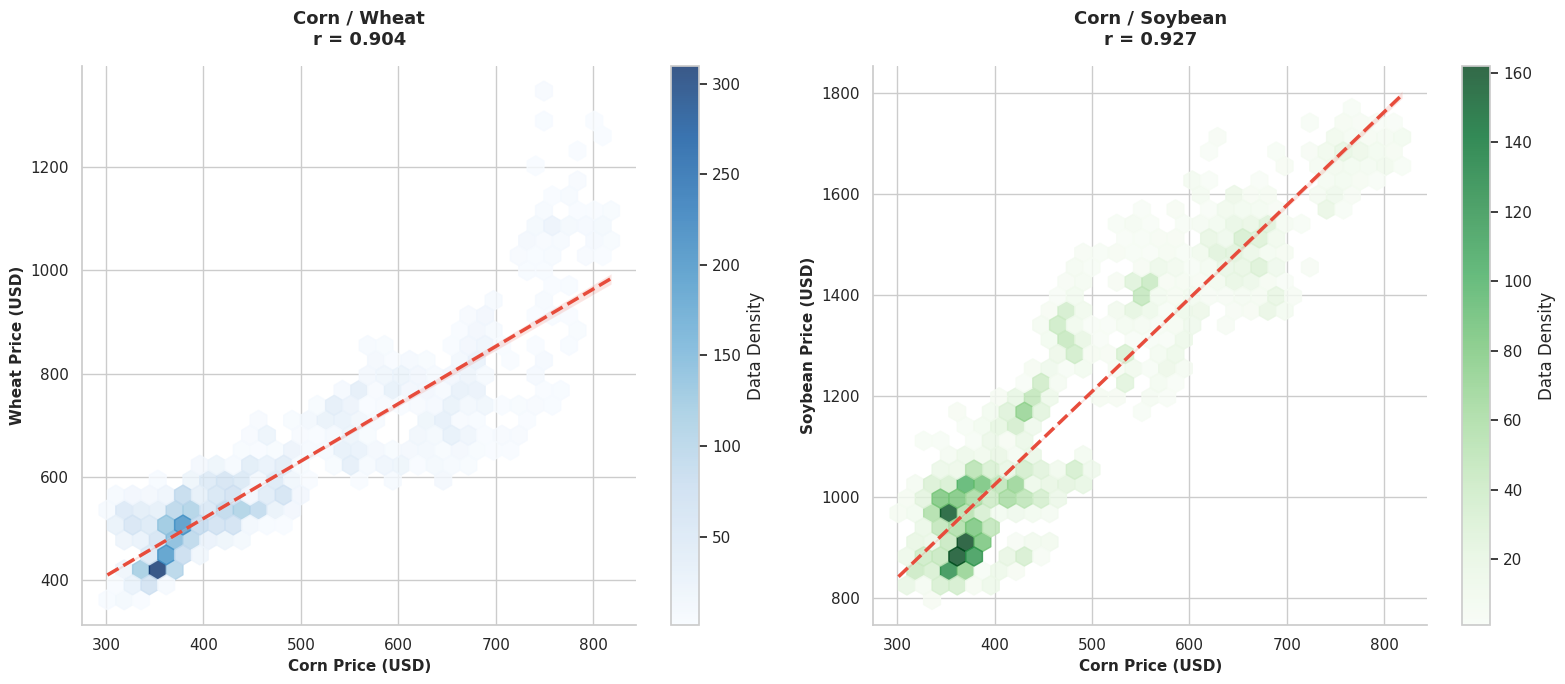

In [11]:
def plot_commodity_correlations_advanced(df, sample_size=5000):
    pairs = [
        ('futures_close_ZC_1', 'futures_close_ZW_1', 'Corn / Wheat'),
        ('futures_close_ZC_1', 'futures_close_ZS_1', 'Corn / Soybean')
    ]
    
    colors = ['#3498db', '#27ae60']
    
    fig = plt.figure(figsize=(16, 7))
    
    for idx, (col_x, col_y, title) in enumerate(pairs):
        # Sample data
        sample = df[[col_x, col_y]].dropna().sample(
            min(sample_size, len(df[[col_x, col_y]].dropna()))
        )
        
        # Create subplot grid
        ax = plt.subplot(1, 2, idx + 1)
        
        # Hexbin plot for density visualization
        hexbin = ax.hexbin(
            sample[col_x], 
            sample[col_y], 
            gridsize=30, 
            cmap='Blues' if idx == 0 else 'Greens',
            mincnt=1,
            alpha=0.8
        )
        
        # Regression line
        sns.regplot(
            data=sample, 
            x=col_x, 
            y=col_y, 
            scatter=False,
            color='#e74c3c',
            line_kws={'linewidth': 2.5, 'linestyle': '--'},
            ax=ax
        )
        
        # Calculate correlation
        corr = sample[col_x].corr(sample[col_y])
        
        # Labels
        labels = ['Corn', 'Wheat'] if idx == 0 else ['Corn', 'Soybean']
        ax.set_xlabel(f'{labels[0]} Price (USD)', fontsize=11, fontweight='600')
        ax.set_ylabel(f'{labels[1]} Price (USD)', fontsize=11, fontweight='600')
        ax.set_title(f'{title}\nr = {corr:.3f}', fontsize=13, fontweight='bold', pad=15)
        
        # Add colorbar
        plt.colorbar(hexbin, ax=ax, label='Data Density')
        
        # Clean up spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

# Usage
fig = plot_commodity_correlations_advanced(master_df)
plt.show()

## Geospatial Analysis
Calculate climate risk scores for each risk category.
    
    Risk score is calculated as: (medium_count + 2 × high_count) / total_count
    This weights high-risk locations more heavily than medium-risk ones.

Calculating risk scores...
Aggregating risk scores by country...
Generating plot...
Saved plot to geospatial_risk_by_country.png


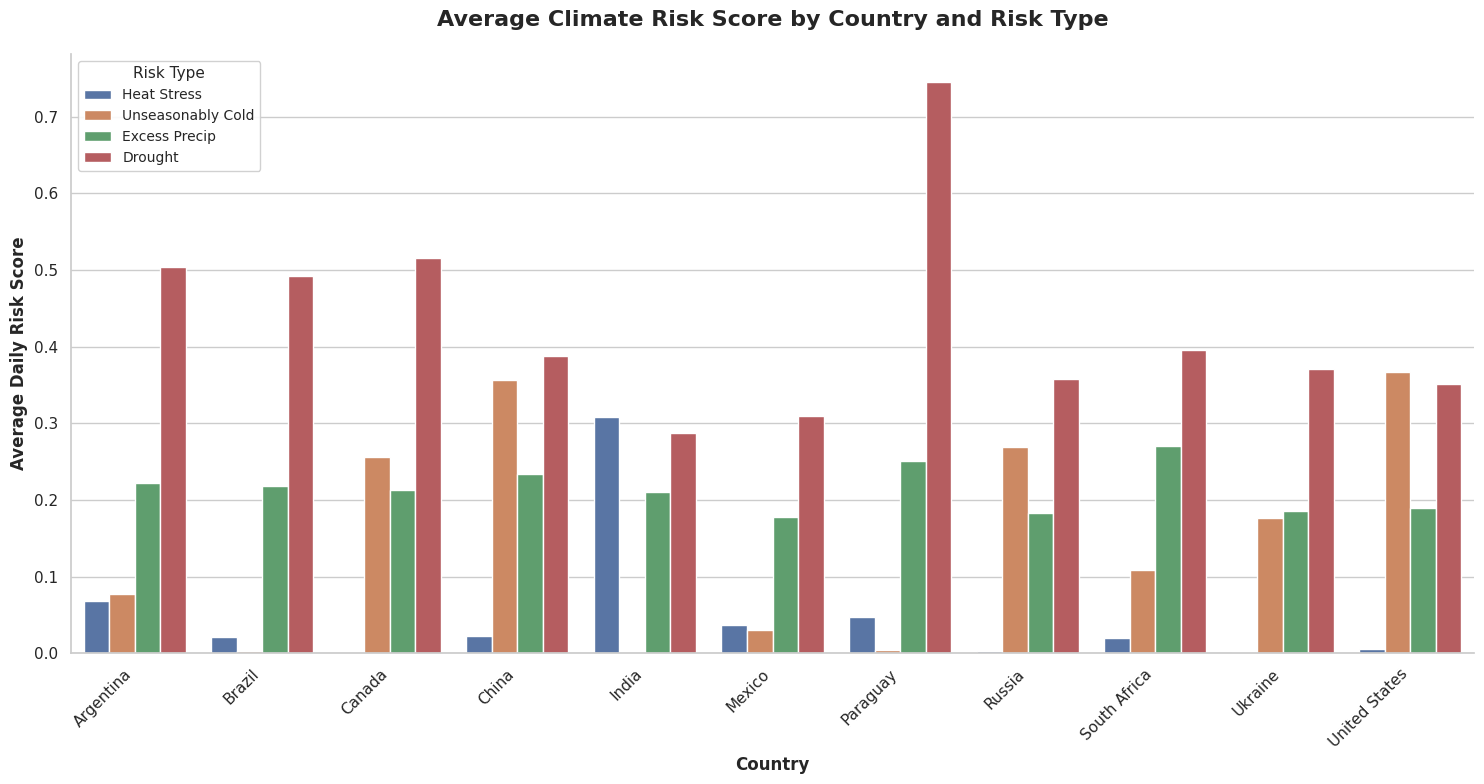

In [12]:
RISK_CATEGORIES = ['heat_stress', 'unseasonably_cold', 'excess_precip', 'drought']

def calculate_climate_risk_scores(df, risk_categories=RISK_CATEGORIES):
    df_copy = df.copy()
    
    print("Calculating risk scores...")
    for risk_type in risk_categories:
        # Define column names
        low_col = f'climate_risk_cnt_locations_{risk_type}_risk_low'
        med_col = f'climate_risk_cnt_locations_{risk_type}_risk_medium'
        high_col = f'climate_risk_cnt_locations_{risk_type}_risk_high'
        
        # Handle special naming for unseasonably_cold
        if risk_type == 'unseasonably_cold':
            low_col = 'climate_risk_cnt_locations_unseasonably_cold_risk_low'
            med_col = 'climate_risk_cnt_locations_unseasonably_cold_risk_medium'
            high_col = 'climate_risk_cnt_locations_unseasonably_cold_risk_high'
        
        # Calculate weighted risk score
        total = df_copy[low_col] + df_copy[med_col] + df_copy[high_col]
        df_copy[f'climate_risk_{risk_type}_score'] = (
            df_copy[med_col] + 2 * df_copy[high_col]
        ) / (total + 1e-6)  # Add epsilon to avoid division by zero
    
    return df_copy


def plot_country_risk_comparison(df, risk_categories=RISK_CATEGORIES, save_path=None):
    """
    Create bar plot comparing average climate risk scores across countries.
    
    Aggregates risk scores by country and visualizes them in a grouped bar chart
    to compare different risk types across geographical regions.
    """
    print("Aggregating risk scores by country...")
    
    # Calculate mean risk score per country
    score_cols = [f'climate_risk_{risk_type}_score' for risk_type in risk_categories]
    country_risk_mean = df.groupby('country_name')[score_cols].mean().reset_index()
    
    # Reshape data for seaborn
    country_risk_melted = country_risk_mean.melt(
        id_vars='country_name',
        var_name='risk_type',
        value_name='average_score'
    )
    
    # Clean up risk type labels for display
    country_risk_melted['risk_type'] = (
        country_risk_melted['risk_type']
        .str.replace('climate_risk_', '')
        .str.replace('_score', '')
        .str.replace('_', ' ')
        .str.title()
    )
    
    # Create plot
    print("Generating plot...")
    fig, ax = plt.subplots(figsize=(15, 8))
    
    sns.barplot(
        data=country_risk_melted, 
        x='country_name', 
        y='average_score', 
        hue='risk_type',
        ax=ax
    )
    
    # Styling
    ax.set_title('Average Climate Risk Score by Country and Risk Type', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Country', fontsize=12, fontweight='600')
    ax.set_ylabel('Average Daily Risk Score', fontsize=12, fontweight='600')
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    
    # Legend
    ax.legend(title='Risk Type', title_fontsize=11, fontsize=10, 
              loc='upper left', framealpha=0.9)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    return fig


# Usage
merged_df_copy = calculate_climate_risk_scores(master_df)
fig = plot_country_risk_comparison(
    merged_df_copy, 
    save_path="geospatial_risk_by_country.png"
)
plt.show()

## Price Over Time
Compare futures prices for multiple commodities on a single plot.
    
Normalizes prices to show relative changes from a baseline (first value = 100)
to make different commodities comparable.


--- Generating Multi-Commodity Price Comparison ---
Saved multi-commodity plot to multi_commodity_comparison.png


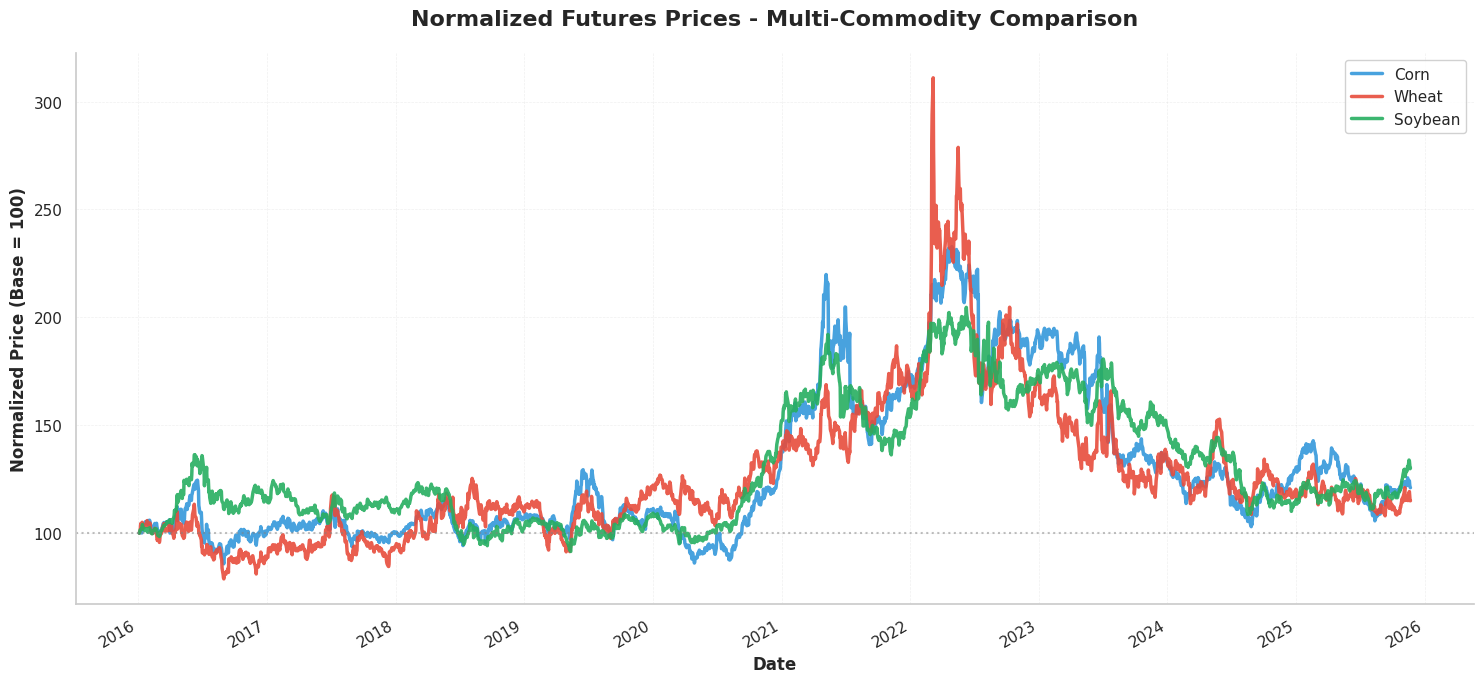

In [13]:
def plot_multiple_futures_prices(df, commodities=['ZC', 'ZW', 'ZS'], 
                                  contract='1', save_path=None):
    print("\n--- Generating Multi-Commodity Price Comparison ---")
    
    commodity_names = {
        'ZC': 'Corn',
        'ZW': 'Wheat',
        'ZS': 'Soybean'
    }
    
    colors = ['#3498db', '#e74c3c', '#27ae60']
    price_cols = [f'futures_close_{commodity}_{contract}' for commodity in commodities]
    
    # Filter and sort ONCE for all commodities
    plot_data = df[['date_on'] + price_cols].copy()
    plot_data = plot_data.sort_values('date_on')
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    for idx, commodity in enumerate(commodities):
        price_col = f'futures_close_{commodity}_{contract}'
        
        if price_col not in df.columns:
            print(f"Warning: {price_col} not found in DataFrame")
            continue
        
        # Get clean data for this commodity
        commodity_data = plot_data[['date_on', price_col]].dropna()
        
        if len(commodity_data) == 0:
            print(f"Warning: No data available for {commodity}")
            continue
        
        # Normalize to index (first value = 100)
        first_value = commodity_data[price_col].iloc[0]
        normalized = (commodity_data[price_col] / first_value) * 100
        
        # Plot
        ax.plot(
            commodity_data['date_on'],
            normalized,
            linewidth=2.5,
            color=colors[idx],
            label=commodity_names.get(commodity, commodity),
            alpha=0.9
        )
    
    # Styling
    ax.set_title(
        'Normalized Futures Prices - Multi-Commodity Comparison', 
        fontsize=16, 
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel('Date', fontsize=12, fontweight='600')
    ax.set_ylabel('Normalized Price (Base = 100)', fontsize=12, fontweight='600')
    
    # Grid and legend
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.legend(loc='best', framealpha=0.9, fontsize=11)
    
    # Add horizontal line at 100
    ax.axhline(y=100, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig.autofmt_xdate()
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved multi-commodity plot to {save_path}")
    
    return fig


fig2 = plot_multiple_futures_prices(master_df, save_path="multi_commodity_comparison.png")
plt.show()

# Helper Functions

## Compute CFCS Metric
The Climate-Futures Correlation Score (CFCS) is a composite performance metric. It evaluates the relationship between the engineered climate features and futures market variables across different commodities and regions.The metric is designed to be anti-fragile: it penalizes noise and rewards clear, strong signals. 

It uses a weighted formula to calculate final rank:

$$CFCS = (0.5 \times \text{Avg\_Sig\_Score}) + (0.3 \times \text{Max\_Corr\_Score}) + (0.2 \times \text{Sig\_Count\_Score})$$

| Pillar | Weight | Focus | Logic |
| :--- | :---: | :--- | :--- |
| **Consistency** | **50%** | **Avg_Sig_Corr** | Only looks at correlations $\ge \|0.5\|$. Measures the average strength of "meaningful" signals. |
| **Discovery** | **30%** | **Max_Corr** | Rewards the single strongest relationship (breakthrough indicators). |
| **Efficiency** | **20%** | **Sig_Count** | The percentage of the features that reach the $\|0.5\|$ threshold. Penalizes "noise." |

💡 The 50% weight on the average significant correlation means that the goal should be to find features that are robust across multiple countries or commodities. If a feature works perfectly for "Wheat in France" (Corr: 0.8) but fails for everything else (Corr: < 0.5), it will help Max_Corr but might struggle to lift the Avg_Sig_Corr significantly.

In [14]:
def compute_cfcs(df, verbose=1):
    """
    Compute CFCS score for a dataframe.
    CFCS = (0.5 × Avg_Sig_Corr) + (0.3 × Max_Corr) + (0.2 × Sig_Count%)
    """
    
    # Dynamic detection
    climate_cols = [c for c in df.columns if c.startswith("climate_risk_")]
    futures_cols = [c for c in df.columns if c.startswith("futures_")]
    
    correlations = []
    
    # Group by country & month
    for (country, month), group in df.groupby(['country_name', 'date_on_month']):
        if verbose==2:
            print(f"    - Processing: {country}, {month}")
        
        climate_data = group[climate_cols]
        futures_data = group[futures_cols]
        
        # Check variance
        valid_climate = climate_data.columns[climate_data.std() > 0]
        valid_futures = futures_data.columns[futures_data.std() > 0]
        
        if len(valid_climate) == 0 or len(valid_futures) == 0:
            continue
        
        # Calc correlation
        combined = pd.concat([
            climate_data[valid_climate], 
            futures_data[valid_futures]
        ], axis=1)
        
        corr_matrix = combined.corr()
        
        # Just relevant parts (climate × futures)
        for clim in valid_climate:
            for fut in valid_futures:
                correlations.append(corr_matrix.loc[clim, fut])
    
    correlations = pd.Series(correlations).dropna()
    
    if len(correlations) == 0:
        return {
            'cfcs': 0.0,
            'avg_sig_corr': 0.0,
            'max_corr': 0.0,
            'sig_count': 0,
            'total': 0,
            'sig_pct': 0.0,
            'n_features': len(climate_cols)
        }
    
    abs_corrs = correlations.abs()
    sig_corrs = abs_corrs[abs_corrs >= 0.5]
    
    avg_sig = sig_corrs.mean() if len(sig_corrs) > 0 else 0
    max_corr = abs_corrs.max()
    sig_pct = (len(sig_corrs) / len(correlations)) * 100
    
    # CFCS-Calculation
    cfcs = (0.5 * min(100, avg_sig * 100)) + \
           (0.3 * min(100, max_corr * 100)) + \
           (0.2 * sig_pct)
    
    result = {
        'cfcs': round(cfcs, 2),
        'avg_sig_corr': round(avg_sig, 4),
        'max_corr': round(max_corr, 4),
        'sig_count': len(sig_corrs),
        'total': len(correlations),
        'sig_pct': round(sig_pct, 2),
        'n_features': len(climate_cols)
    }
    
    if verbose==1:
        print(f"CFCS: {result['cfcs']} | Sig: {result['sig_count']}/{result['total']} "
              f"({result['sig_pct']:.2f}%) | Features: {result['n_features']}")
    
    return result

## Analyze Feature Contribution
Computes correlation statistics between each climate risk feature and all futures variables across different countries and months. Returns a feature-level CFCS score to identify which climate features have the strongest predictive relationship with futures prices.

Notes:
- Correlations are computed per country-month group
- Only features/futures with non-zero variance are included
- Significance threshold is |correlation| ≥ 0.5
- Feature CFCS score uses same formula as global CFCS but per feature

In [15]:
def analyze_feature_contributions(df, climate_cols, futures_cols, verbose=1):
    """
    Analyze contribution of each climate feature.
    Returns DataFrame with sig_count, max_corr, etc for each feature.
    """
    # Initialisierung mit defaultdict für cleaner Code
    from collections import defaultdict
    feature_stats = defaultdict(lambda: {
        'sig_count': 0, 
        'total': 0, 
        'max_corr': 0, 
        'sig_corrs': []
    })

    current_country = None
    
    # Verwende groupby statt verschachtelter Filterungen
    for (country, month), group in df.groupby(['country_name', 'date_on_month']):
        if verbose == 2:
            print(f"    - Analyze: {country}, {month}")
        elif verbose == 1 and country != current_country:
            print(f"    - Analyze contribution for country: {country}")
            current_country = country
        
        # Varianz-Check einmal pro Gruppe
        climate_data = group[climate_cols]
        futures_data = group[futures_cols]
        
        valid_climate = climate_data.columns[climate_data.std() > 0]
        valid_futures = futures_data.columns[futures_data.std() > 0]
        
        if len(valid_climate) == 0 or len(valid_futures) == 0:
            continue
        
        # Korrelationsmatrix einmal berechnen
        combined = pd.concat([
            climate_data[valid_climate], 
            futures_data[valid_futures]
        ], axis=1)
        
        corr_matrix = combined.corr()
        
        # Extrahiere alle Korrelationen für jeden climate feature
        for clim in valid_climate:
            # Hole alle Korrelationen dieses Features mit allen Futures
            clim_corrs = corr_matrix.loc[clim, valid_futures].dropna()
            abs_corrs = clim_corrs.abs()
            
            feature_stats[clim]['total'] += len(abs_corrs)
            
            # Finde signifikante Korrelationen
            sig_mask = abs_corrs >= 0.5
            sig_values = abs_corrs[sig_mask]
            
            feature_stats[clim]['sig_count'] += len(sig_values)
            feature_stats[clim]['sig_corrs'].extend(sig_values.tolist())
            
            # Update max_corr
            current_max = abs_corrs.max()
            if current_max > feature_stats[clim]['max_corr']:
                feature_stats[clim]['max_corr'] = current_max
    
    # Calc final statistics
    results = []
    for col in climate_cols:
        stats = feature_stats[col]
        
        avg_sig = np.mean(stats['sig_corrs']) if stats['sig_corrs'] else 0
        max_corr = stats['max_corr']
        sig_pct = (stats['sig_count'] / stats['total'] * 100) if stats['total'] > 0 else 0
        
        # CFCS-Score
        feature_cfcs = (0.5 * min(100, avg_sig * 100)) + \
                       (0.3 * min(100, max_corr * 100)) + \
                       (0.2 * sig_pct)
        
        results.append({
            'feature': col,
            'feature_cfcs': round(feature_cfcs, 2),
            'sig_count': stats['sig_count'],
            'total': stats['total'],
            'sig_pct': round(sig_pct, 2),
            'max_corr': round(max_corr, 4),
            'avg_sig_corr': round(avg_sig, 4)
        })
    
    return pd.DataFrame(results).sort_values('feature_cfcs', ascending=False)

# Feature Engineering

In [16]:
# Create a working copy
merged_df = master_df.copy()

# Add basic time features
merged_df['day_of_year'] = merged_df['date_on'].dt.dayofyear
merged_df['quarter'] = merged_df['date_on'].dt.quarter
merged_df['date_on_day'] = merged_df['date_on'].dt.day

print("Added basic time features")
print(f"Dataset shape: {merged_df.shape}")

Added basic time features
Dataset shape: (320661, 44)


In [17]:
# Merge market share
merged_df = merged_df.merge(
    market_share_df[['region_id', 'percent_country_production']], 
    on='region_id', how='left'
)
merged_df['percent_country_production'] = merged_df['percent_country_production'].fillna(1.0)

print("Merged with market share data")
print(f"Production share range: {merged_df['percent_country_production'].min():.1f}% to {merged_df['percent_country_production'].max():.1f}%")

Merged with market share data
Production share range: 0.0% to 73.0%


## Meteo

### Basic Features

In [18]:
# Temperature Mean (forr GDD-Calc)
meteo_df['climate_risk_meteo_temperature_mean'] = (meteo_df['temperature_2m_max'] + meteo_df['temperature_2m_min']) / 2

# Growing Degree Days (GDD) for Corn
# Base: 10°C (lower threshold), 30°C (upper threshold)
meteo_df['climate_risk_meteo_gdd'] = meteo_df.apply(
    lambda row: max(0, min(30, row['climate_risk_meteo_temperature_mean']) - 10), 
    axis=1
)

# Extreme Temperatur-Events
meteo_df['climate_risk_meteo_extreme_heat_day'] = (meteo_df['temperature_2m_max'] > 35).astype(int)
meteo_df['climate_risk_meteo_heat_stress_day'] = (meteo_df['temperature_2m_max'] > 32).astype(int)

# Precipitation Features
meteo_df['climate_risk_meteo_is_dry_day'] = (meteo_df['precipitation_sum'] < 1).astype(int)
meteo_df['climate_risk_meteo_heavy_rain_day'] = (meteo_df['precipitation_sum'] > 25).astype(int)

# Evapotranspiration Deficit (simplified)
meteo_df['climate_risk_meteo_et_deficit'] = meteo_df['et0_fao_evapotranspiration_sum'] - meteo_df['precipitation_sum']
meteo_df['climate_risk_meteo_et_deficit'] = meteo_df['climate_risk_meteo_et_deficit'].clip(lower=0)  # Nur positive Defizite

# Soil Moisture Combinations
meteo_df['climate_risk_meteo_soil_moisture_avg'] = (
    meteo_df['soil_moisture_0_to_7cm_mean'] + 
    meteo_df['soil_moisture_7_to_28cm_mean']
) / 2

# Temperature Difference (Daily Amplitude)
meteo_df['climate_risk_meteo_temp_range'] = meteo_df['temperature_2m_max'] - meteo_df['temperature_2m_min']

### Rolling Aggregtaion (grouped regional)

In [19]:
groupby_cols = ['country', 'region']
windows = [7, 14, 30, 60, 90, 120]

# Pre-calculate grouped objects (reuse for efficiency)
grouped = meteo_df.groupby(groupby_cols)

new_columns = {}

for window in windows:
    new_columns.update({
        f'climate_risk_meteo_temp_mean_{window}d': grouped['climate_risk_meteo_temperature_mean'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        ),
        f'climate_risk_meteo_temp_max_{window}d': grouped['temperature_2m_max'].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        ),
        f'climate_risk_meteo_gdd_cumsum_{window}d': grouped['climate_risk_meteo_gdd'].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        ),
        f'climate_risk_meteo_precip_sum_{window}d': grouped['precipitation_sum'].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        ),
        f'climate_risk_meteo_precip_mean_{window}d': grouped['precipitation_sum'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        ),
        f'climate_risk_meteo_et_deficit_sum_{window}d': grouped['climate_risk_meteo_et_deficit'].transform(
            lambda x: x.rolling(window, min_periods=1).sum()
        ),
        f'climate_risk_meteo_soil_moisture_mean_{window}d': grouped['climate_risk_meteo_soil_moisture_avg'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        ),
    })

# Add all columns at once - no fragmentation!
meteo_df = pd.concat([meteo_df, pd.DataFrame(new_columns, index=meteo_df.index)], axis=1)

### Weather Risk Indicators Calculation

In [20]:
# Consecutive Dry Days
meteo_df['climate_risk_meteo_dry_spell_length'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_is_dry_day'].transform(
    lambda x: x.groupby((x != x.shift()).cumsum()).cumsum()
)

# Extreme Event Counts
for window in [30, 60, 90]:
    meteo_df[f'climate_risk_meteo_extreme_heat_count_{window}d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_extreme_heat_day'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )
    
    meteo_df[f'climate_risk_meteo_heat_stress_count_{window}d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_heat_stress_day'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )
    
    meteo_df[f'climate_risk_meteo_heavy_rain_count_{window}d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_heavy_rain_day'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )

# Max Dry Spell in last N days
for window in [30, 60, 90]:
    meteo_df[f'climate_risk_meteo_max_dry_spell_{window}d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_dry_spell_length'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )

### Anomalies
Deviations from Long-term Average

In [21]:
# longtime-mean (365 Tage)
meteo_df['climate_risk_meteo_temp_longterm_avg'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_temperature_mean'].transform(
    lambda x: x.rolling(window=365, min_periods=180).mean()
)

meteo_df['climate_risk_meteo_precip_longterm_avg'] = meteo_df.groupby(groupby_cols)['precipitation_sum'].transform(
    lambda x: x.rolling(window=365, min_periods=180).mean()
)

### GDD Features
This code creates comprehensive Growing Degree Days (GDD) features for corn climate risk prediction by tracking crop development progress through six critical growth stages (from emergence at 100 GDD to maturity at 1500 GDD). It calculates GDD deficits, surpluses, and accumulation rates while identifying stress conditions during critical periods like flowering and grain fill. The code generates temporal momentum features (trends, velocities, accelerations) and combines GDD with other meteorological factors (drought, heat stress, soil moisture) to create compound risk indicators. Finally, it produces regional comparisons, phase-specific ratios, and various mathematical transformations (log, sqrt, binning) to capture non-linear relationships between GDD and crop yield risk.

In [22]:
# GDD Deficit (Comparison with target values)
# For corn: ~1400-1600 GDD for full maturity
meteo_df['climate_risk_meteo_gdd_cumsum_season'] = meteo_df.groupby(
    groupby_cols + ['growing_season_year'] if 'growing_season_year' in meteo_df.columns else groupby_cols
)['climate_risk_meteo_gdd'].transform('cumsum')

# GDD Rate (how quickly are GDD accumulating?)
meteo_df['climate_risk_meteo_gdd_rate_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)

# GDD Anomaly
meteo_df['climate_risk_meteo_gdd_anomaly'] = meteo_df['climate_risk_meteo_gdd'] - meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd'].transform(
    lambda x: x.rolling(window=365, min_periods=180).mean()
)


# -----------------------------------------------------------------------------
# GDD DEFICIT/SURPLUS FEATURES
# -----------------------------------------------------------------------------

# Calculate day of year (for seasonal comparison)
meteo_df['day_of_season'] = meteo_df.groupby(
    groupby_cols + ['growing_season_year'] if 'growing_season_year' in meteo_df.columns else groupby_cols
).cumcount() + 1

# Expected GDD based on day of season (linearly interpolated to 1500 GDD over ~150 days)
meteo_df['climate_risk_meteo_gdd_expected'] = np.minimum(
    meteo_df['day_of_season'] * 10,  # ~10 GDD per day on average
    1500
)

# GDD Deficit (negative = too little, positive = too much)
meteo_df['climate_risk_meteo_gdd_deficit'] = (
    meteo_df['climate_risk_meteo_gdd_cumsum_season'] - 
    meteo_df['climate_risk_meteo_gdd_expected']
)

# Relative GDD Deficit (percentage)
meteo_df['climate_risk_meteo_gdd_deficit_pct'] = (
    meteo_df['climate_risk_meteo_gdd_deficit'] / 
    (meteo_df['climate_risk_meteo_gdd_expected'] + 1)  # +1 to avoid division by zero
)

# Critical Deficit (more than 20% behind target)
meteo_df['climate_risk_meteo_gdd_critical_deficit'] = (
    meteo_df['climate_risk_meteo_gdd_deficit_pct'] < -0.2
).astype(int)

# -----------------------------------------------------------------------------
# GDD ACCELERATION FEATURES (Growth Rate)
# -----------------------------------------------------------------------------

# GDD Acceleration
meteo_df['climate_risk_meteo_gdd_acceleration_7d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean() - x.rolling(window=14, min_periods=1).mean()
)

# GDD Velocity Score
meteo_df['climate_risk_meteo_gdd_velocity_14d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd'].transform(
    lambda x: x.rolling(window=14, min_periods=1).sum()
)

meteo_df['climate_risk_meteo_gdd_velocity_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd'].transform(
    lambda x: x.rolling(window=30, min_periods=1).sum()
)

# Ratio: current velocity vs. seasonal average
meteo_df['climate_risk_meteo_gdd_velocity_ratio'] = (
    meteo_df['climate_risk_meteo_gdd_velocity_14d'] / 
    (meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_velocity_14d'].transform(
        lambda x: x.rolling(window=365, min_periods=30).mean()
    ) + 0.1)  # +0.1 to avoid division by zero
)

# -----------------------------------------------------------------------------
# GDD EFFICIENCY FEATURES
# -----------------------------------------------------------------------------

# GDD Efficiency: GDD per mm precipitation
meteo_df['climate_risk_meteo_gdd_per_precip_30d'] = (
    meteo_df['climate_risk_meteo_gdd_cumsum_30d'] / 
    (meteo_df['climate_risk_meteo_precip_sum_30d'] + 1)  # +1 to avoid division by zero
)

# GDD under stress conditions
meteo_df['climate_risk_meteo_gdd_under_drought'] = (
    meteo_df['climate_risk_meteo_gdd'] * 
    meteo_df['climate_risk_meteo_is_dry_day']
)

meteo_df['climate_risk_meteo_gdd_under_drought_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_under_drought'].transform(
    lambda x: x.rolling(window=30, min_periods=1).sum()
)

# GDD under extreme heat (>35°C can be harmful)
meteo_df['climate_risk_meteo_gdd_extreme_heat'] = (
    meteo_df['climate_risk_meteo_gdd'] * 
    meteo_df['climate_risk_meteo_extreme_heat_day']
)

meteo_df['climate_risk_meteo_gdd_extreme_heat_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_extreme_heat'].transform(
    lambda x: x.rolling(window=30, min_periods=1).sum()
)

# -----------------------------------------------------------------------------
# CRITICAL PHASE-SPECIFIC GDD FEATURES
# -----------------------------------------------------------------------------

# Extract month if not already available
if 'month' not in meteo_df.columns:
    meteo_df['month'] = pd.to_datetime(meteo_df['date']).dt.month

# Critical Grain Fill Period (July-August for Northern Hemisphere)
meteo_df['is_grain_fill_period'] = meteo_df['month'].isin([7, 8]).astype(int)

# GDD during critical period
meteo_df['climate_risk_meteo_gdd_grain_fill'] = (
    meteo_df['climate_risk_meteo_gdd'] * 
    meteo_df['is_grain_fill_period']
)

meteo_df['climate_risk_meteo_gdd_grain_fill_cumsum'] = meteo_df.groupby(
    groupby_cols + (['growing_season_year'] if 'growing_season_year' in meteo_df.columns else [])
)['climate_risk_meteo_gdd_grain_fill'].transform('cumsum')

# Flowering/Pollination Period (June-July)
meteo_df['is_flowering_period'] = meteo_df['month'].isin([6, 7]).astype(int)

meteo_df['climate_risk_meteo_gdd_flowering'] = (
    meteo_df['climate_risk_meteo_gdd'] * 
    meteo_df['is_flowering_period']
)

meteo_df['climate_risk_meteo_gdd_flowering_cumsum'] = meteo_df.groupby(
    groupby_cols + (['growing_season_year'] if 'growing_season_year' in meteo_df.columns else [])
)['climate_risk_meteo_gdd_flowering'].transform('cumsum')

# -----------------------------------------------------------------------------
# TRANSFORMATIONS OF ORIGINAL GDD_CUMSUM_SEASON
# -----------------------------------------------------------------------------

# Log-Transformation (for better linearity)
meteo_df['climate_risk_meteo_gdd_cumsum_season_log'] = np.log1p(
    meteo_df['climate_risk_meteo_gdd_cumsum_season']
)

# Sqrt-Transformation
meteo_df['climate_risk_meteo_gdd_cumsum_season_sqrt'] = np.sqrt(
    meteo_df['climate_risk_meteo_gdd_cumsum_season']
)

# Squared (for non-linear relationships)
meteo_df['climate_risk_meteo_gdd_cumsum_season_sq'] = (
    meteo_df['climate_risk_meteo_gdd_cumsum_season'] ** 2
)

# Binned GDD (categorical)
meteo_df['climate_risk_meteo_gdd_cumsum_season_binned'] = pd.cut(
    meteo_df['climate_risk_meteo_gdd_cumsum_season'],
    bins=[0, 300, 600, 900, 1200, 1500, 10000],
    labels=[1, 2, 3, 4, 5, 6]
)
meteo_df['climate_risk_meteo_gdd_cumsum_season_binned'] = meteo_df['climate_risk_meteo_gdd_cumsum_season_binned'].cat.codes.replace(-1, np.nan)
meteo_df['climate_risk_meteo_gdd_cumsum_season_binned'] = meteo_df['climate_risk_meteo_gdd_cumsum_season_binned'] + 1

# -----------------------------------------------------------------------------
# SEASONAL NORMALIZATION
# -----------------------------------------------------------------------------

# GDD normalized for each region (Z-Score)
meteo_df['climate_risk_meteo_gdd_cumsum_season_zscore'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_cumsum_season'].transform(
    lambda x: (x - x.mean()) / (x.std() + 0.1)
)

# GDD as % of regional maximum
meteo_df['climate_risk_meteo_gdd_cumsum_season_pct_max'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_cumsum_season'].transform(
    lambda x: x / (x.max() + 1)
)

# -----------------------------------------------------------------------------
# INTERACTIONS WITH OTHER METEO FEATURES
# -----------------------------------------------------------------------------

# GDD × Drought Stress
if 'climate_risk_meteo_dry_spell_length' in meteo_df.columns:
    meteo_df['climate_risk_meteo_gdd_x_drought'] = (
        meteo_df['climate_risk_meteo_gdd_cumsum_season'] * 
        meteo_df['climate_risk_meteo_dry_spell_length']
    )

# GDD × ET Deficit
if 'climate_risk_meteo_et_deficit_sum_60d' in meteo_df.columns:
    meteo_df['climate_risk_meteo_gdd_x_et_deficit'] = (
        meteo_df['climate_risk_meteo_gdd_cumsum_season'] * 
        meteo_df['climate_risk_meteo_et_deficit_sum_60d']
    )

# GDD × Soil Moisture
if 'climate_risk_meteo_soil_moisture_mean_30d' in meteo_df.columns:
    meteo_df['climate_risk_meteo_gdd_x_soil_moisture'] = (
        meteo_df['climate_risk_meteo_gdd_cumsum_season'] * 
        meteo_df['climate_risk_meteo_soil_moisture_mean_30d']
    )

# GDD Deficit × Heat Stress
if 'climate_risk_meteo_heat_stress_count_30d' in meteo_df.columns:
    meteo_df['climate_risk_meteo_gdd_deficit_x_heat'] = (
        meteo_df['climate_risk_meteo_gdd_deficit'] * 
        meteo_df['climate_risk_meteo_heat_stress_count_30d']
    )

# -----------------------------------------------------------------------------
# WEATHER CODE FEATURES (if available)
# -----------------------------------------------------------------------------

if 'weather_code' in meteo_df.columns:
    # Count unfavorable weather codes
    # WMO Codes: 51-67 (precipitation), 71-77 (snow), 80-99 (showers/thunderstorms)
    meteo_df['climate_risk_meteo_adverse_weather'] = meteo_df['weather_code'].isin(
        list(range(51, 68)) + list(range(71, 78)) + list(range(80, 100))
    ).astype(int)
    
    meteo_df['climate_risk_meteo_adverse_weather_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_adverse_weather'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )


# GDD Deficit relative to regional average
meteo_df['climate_risk_meteo_gdd_deficit_regional_zscore'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_deficit'].transform(
    lambda x: (x - x.mean()) / (x.std() + 0.1)
)

# Ranking within region (0-1, where does this region currently stand?)
meteo_df['climate_risk_meteo_gdd_cumsum_regional_rank'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_cumsum_season'].transform(
    lambda x: x.rank(pct=True)
)

# =============================================================================
# TEMPORAL MOMENTUM FEATURES
# =============================================================================


# Rate of change of GDD deficit
meteo_df['climate_risk_meteo_gdd_deficit_change_rate'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_deficit'].transform(
    lambda x: x.pct_change(periods=7).fillna(0)
)

# =============================================================================
# COMPOUND STRESS INDICES
# =============================================================================

# Weighted Stress Score (meteo factors only)
meteo_df['climate_risk_meteo_weighted_stress_score'] = (
    (meteo_df['climate_risk_meteo_gdd_deficit_pct'].clip(-1, 1) * -3) +  # Deficit very important
    (meteo_df['climate_risk_meteo_dry_spell_length'] / 10) +
    (meteo_df['climate_risk_meteo_extreme_heat_count_30d'] / 5) +
    (meteo_df['climate_risk_meteo_et_deficit_sum_60d'] / 100)
)



# =============================================================================
# EXPONENTIAL WEIGHTED FEATURES
# =============================================================================

# EMA of GDD deficit (recent deficits more important)
meteo_df['climate_risk_meteo_gdd_deficit_ema_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_deficit'].transform(
    lambda x: x.ewm(span=30, min_periods=1).mean()
)

# EMA of stress score
meteo_df['climate_risk_meteo_stress_ema_30d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_weighted_stress_score'].transform(
    lambda x: x.ewm(span=30, min_periods=1).mean()
)


# =============================================================================
# MULTI-WINDOW AGGREGATIONS
# =============================================================================

for window in [45, 75]:
    # GDD Deficit over multiple windows
    meteo_df[f'climate_risk_meteo_gdd_deficit_{window}d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_gdd_deficit'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    # Stress score over different windows
    meteo_df[f'climate_risk_meteo_stress_score_{window}d'] = meteo_df.groupby(groupby_cols)['climate_risk_meteo_weighted_stress_score'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

# =============================================================================
# TRANSFORMATIONS
# =============================================================================

# Log-transformed versions
meteo_df['climate_risk_meteo_gdd_grain_fill_cumsum_log'] = np.log1p(
    meteo_df['climate_risk_meteo_gdd_grain_fill_cumsum']
)

meteo_df['climate_risk_meteo_gdd_flowering_cumsum_log'] = np.log1p(
    meteo_df['climate_risk_meteo_gdd_flowering_cumsum']
)

print(f"✓ Meteo Features created!")
print(f"  Number of new features: {len([c for c in meteo_df.columns if c not in ['date', 'country', 'region', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'et0_fao_evapotranspiration_sum', 'soil_moisture_0_to_7cm_mean', 'soil_moisture_7_to_28cm_mean', 'soil_temperature_0_to_7cm_mean', 'soil_temperature_7_to_28cm_mean', 'shortwave_radiation_sum', 'weather_code']])}")
print(f"  Shape: {meteo_df.shape}")

if USE_EXTERNAL_DATA:
    new_meteo_features = [c for c in meteo_df.columns if c.startswith('climate_risk_meteo_')]
    ALL_NEW_FEATURES.extend(new_meteo_features)

✓ Meteo Features created!
  Number of new features: 114
  Shape: (557935, 127)


## Merge Dataframes

In [23]:
merged_df['date_on'] = pd.to_datetime(merged_df['date_on'])
fred_external_df['date'] = pd.to_datetime(fred_external_df['date'])
meteo_df['date'] = pd.to_datetime(meteo_df['date'])

if USE_EXTERNAL_DATA:
    merged_df = pd.merge(
        merged_df,
        fred_external_df,
        left_on='date_on',
        right_on='date',
        how='left'
    )
    
    merged_df = pd.merge(
        merged_df,
        meteo_df,
        left_on=['date_on', 'region_name'],
        right_on=['date', 'region'],
        how='left'
    )

In [24]:
merged_df.head()

,ID,crop_name,country_name,country_code,region_name,region_id,harvest_period,growing_season_year,date_on,climate_risk_cnt_locations_heat_stress_risk_low,climate_risk_cnt_locations_heat_stress_risk_medium,climate_risk_cnt_locations_heat_stress_risk_high,climate_risk_cnt_locations_unseasonably_cold_risk_low,climate_risk_cnt_locations_unseasonably_cold_risk_medium,climate_risk_cnt_locations_unseasonably_cold_risk_high,climate_risk_cnt_locations_excess_precip_risk_low,climate_risk_cnt_locations_excess_precip_risk_medium,climate_risk_cnt_locations_excess_precip_risk_high,climate_risk_cnt_locations_drought_risk_low,climate_risk_cnt_locations_drought_risk_medium,climate_risk_cnt_locations_drought_risk_high,futures_close_ZC_1,futures_close_ZC_2,futures_close_ZW_1,futures_close_ZS_1,futures_zc1_ret_pct,futures_zc1_ret_log,futures_zc_term_spread,futures_zc_term_ratio,futures_zc1_ma_20,futures_zc1_ma_60,futures_zc1_ma_120,futures_zc1_vol_20,futures_zc1_vol_60,futures_zw_zc_spread,futures_zc_zw_ratio,futures_zs_zc_spread,futures_zc_zs_ratio,date_on_year,date_on_month,date_on_year_month,day_of_year,quarter,date_on_day,percent_country_production,date_x,dollar_index,oil_price,interest_rate,cpi,unemployment_rate,gdp_china,gdp_mexico,industrial_production,natural_gas_price,trucking_ppi,vix,ppi_farm_products,pce_price_index,high_yield_spread,treasury_10y_rate,us_imports,us_exports,dollar_index_filled,oil_price_filled,vix_filled,cpi_filled,gdp_china_filled,gdp_mexico_filled,industrial_production_filled,interest_rate_filled,unemployment_rate_filled,treasury_10y_rate_filled,date_y,temperature_2m_max,temperature_2m_min,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_temperature_0_to_7cm_mean,soil_temperature_7_to_28cm_mean,et0_fao_evapotranspiration_sum,precipitation_sum,shortwave_radiation_sum,weather_code,country,region,climate_risk_meteo_temperature_mean,climate_risk_meteo_gdd,climate_risk_meteo_extreme_heat_day,climate_risk_meteo_heat_stress_day,climate_risk_meteo_is_dry_day,climate_risk_meteo_heavy_rain_day,climate_risk_meteo_et_deficit,climate_risk_meteo_soil_moisture_avg,climate_risk_meteo_temp_range,climate_risk_meteo_temp_mean_7d,climate_risk_meteo_temp_max_7d,climate_risk_meteo_gdd_cumsum_7d,climate_risk_meteo_precip_sum_7d,climate_risk_meteo_precip_mean_7d,climate_risk_meteo_et_deficit_sum_7d,climate_risk_meteo_soil_moisture_mean_7d,climate_risk_meteo_temp_mean_14d,climate_risk_meteo_temp_max_14d,climate_risk_meteo_gdd_cumsum_14d,climate_risk_meteo_precip_sum_14d,climate_risk_meteo_precip_mean_14d,climate_risk_meteo_et_deficit_sum_14d,climate_risk_meteo_soil_moisture_mean_14d,climate_risk_meteo_temp_mean_30d,climate_risk_meteo_temp_max_30d,climate_risk_meteo_gdd_cumsum_30d,climate_risk_meteo_precip_sum_30d,climate_risk_meteo_precip_mean_30d,climate_risk_meteo_et_deficit_sum_30d,climate_risk_meteo_soil_moisture_mean_30d,climate_risk_meteo_temp_mean_60d,climate_risk_meteo_temp_max_60d,climate_risk_meteo_gdd_cumsum_60d,climate_risk_meteo_precip_sum_60d,climate_risk_meteo_precip_mean_60d,climate_risk_meteo_et_deficit_sum_60d,climate_risk_meteo_soil_moisture_mean_60d,climate_risk_meteo_temp_mean_90d,climate_risk_meteo_temp_max_90d,climate_risk_meteo_gdd_cumsum_90d,climate_risk_meteo_precip_sum_90d,climate_risk_meteo_precip_mean_90d,climate_risk_meteo_et_deficit_sum_90d,climate_risk_meteo_soil_moisture_mean_90d,climate_risk_meteo_temp_mean_120d,climate_risk_meteo_temp_max_120d,climate_risk_meteo_gdd_cumsum_120d,climate_risk_meteo_precip_sum_120d,climate_risk_meteo_precip_mean_120d,climate_risk_meteo_et_deficit_sum_120d,climate_risk_meteo_soil_moisture_mean_120d,climate_risk_meteo_dry_spell_length,climate_risk_meteo_extreme_heat_count_30d,climate_risk_meteo_heat_stress_count_30d,climate_risk_meteo_heavy_rain_count_30d,climate_risk_meteo_extreme_heat_count_60d,climate_risk_meteo_heat_stress_count_60d,climate_risk_meteo_heavy_rain_count_60d,climate_risk_meteo_extreme_heat_count_90d,climate_risk_meteo_heat_stress_count_90d,climate_ri

## Growing Season Feature: Hemisphere-Specific Seasonality
Creates binary indicator for agricultural growing seasons based on geography.
 - Northern Hemisphere (US, China, Russia, etc.): May-September
 - Southern Hemisphere (Brazil, Argentina, etc.): December-May

In [25]:
def get_seasonality_mask(row):
    c = row['country_name']
    m = row['date_on_month']
    if c in ['United States', 'China', 'Russia', 'Ukraine', 'Canada', 'Romania', 'Hungary']:
        return 1 if m in [5, 6, 7, 8, 9] else 0 
    elif c in ['Brazil', 'Argentina', 'South Africa', 'Paraguay']:
        return 1 if m in [12, 1, 2, 3, 4, 5] else 0 
    return 0
    
merged_df['is_growing_season'] = merged_df.apply(get_seasonality_mask, axis=1)
print("✅ Growing Season Feature created for temporary feature engineering.")

✅ Growing Season Feature created for temporary feature engineering.


## Baseline Features

In [26]:
# --- Base Risk Scores ---
base_risk_features = {}
for risk_type in RISK_CATEGORIES:
    low_col = f'climate_risk_cnt_locations_{risk_type}_risk_low'
    med_col = f'climate_risk_cnt_locations_{risk_type}_risk_medium'
    high_col = f'climate_risk_cnt_locations_{risk_type}_risk_high'
    
    total = merged_df[low_col] + merged_df[med_col] + merged_df[high_col]
    risk_score = (merged_df[med_col] + HIGH_RISK_MULTIPLIER * merged_df[high_col]) / (total + 1e-6)
    weighted = risk_score * (merged_df['percent_country_production'] / 100) * merged_df['is_growing_season']
    
    # Define column names
    score_col_name = f'climate_risk_{risk_type}_score'
    weighted_col_name = f'climate_risk_{risk_type}_weighted'
    pct_high_col_name = f'climate_risk_{risk_type}_pct_high'
    pct_medium_col_name = f'climate_risk_{risk_type}_pct_medium'
    pct_high_medium_col_name = f'climate_risk_{risk_type}_pct_high_medium'
    
    # Add to dictionary
    base_risk_features[score_col_name] = risk_score
    base_risk_features[weighted_col_name] = weighted
    base_risk_features[pct_high_col_name] = merged_df[high_col] / (total + 1e-6)
    base_risk_features[pct_medium_col_name] = merged_df[med_col] / (total + 1e-6)
    base_risk_features[pct_high_medium_col_name] = (merged_df[high_col] + merged_df[med_col]) / (total + 1e-6)
    
    # Track new features
    ALL_NEW_FEATURES.extend([
        score_col_name, weighted_col_name, pct_high_col_name,
        pct_medium_col_name, pct_high_medium_col_name
    ])

merged_df = pd.concat([merged_df, pd.DataFrame(base_risk_features)], axis=1)
print(f"✅ Base risk scores created: {len(ALL_NEW_FEATURES)} total features")

✅ Base risk scores created: 130 total features


## Time-Series Features
This code generates time-series features from climate risk scores for different regions by calculating rolling statistics (moving averages, maximums, standard deviations) across various time windows.

In [27]:
merged_df = merged_df.sort_values(['region_id', 'date_on'])
ts_features = {}

# Short-Term rolling MA and Max
for window in [7, 14, 30, 60]:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        grouped_ts = merged_df.groupby('region_id')[score_col]
        ma_col = f'climate_risk_{risk_type}_ma_{window}d'
        ts_features[ma_col] = grouped_ts.transform(lambda x: x.rolling(window, min_periods=1).mean())
        ALL_NEW_FEATURES.append(ma_col)

        # Rolling maximum (peak risk)
        max_col = f"climate_risk_{risk_type}_max_{window}d"
        ts_features[max_col] = grouped_ts.transform(lambda x: x.rolling(window, min_periods=1).max())
        ALL_NEW_FEATURES.append(max_col)
        

# Long-term rolling features for top risk types
for window in [90, 180, 270, 320, 365, 400]:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        grouped_ts = merged_df.groupby('region_id')[score_col]
        ma_col = f'climate_risk_{risk_type}_ma_{window}d'
        ts_features[ma_col] = grouped_ts.transform(lambda x: x.rolling(window, min_periods=1).mean())
        ALL_NEW_FEATURES.append(ma_col)

        max_col = f'climate_risk_{risk_type}_max_{window}d'
        ts_features[max_col] = grouped_ts.transform(lambda x: x.rolling(window, min_periods=1).max())
        ALL_NEW_FEATURES.append(max_col)


# Lag features - weather today affects prices in future
for lag in LAGS:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        lag_col = f'climate_risk_{risk_type}_lag_{lag}d'
        ts_features[lag_col] = merged_df.groupby('region_id')[score_col].shift(lag)
        ALL_NEW_FEATURES.append(lag_col)


# Exponential Moving Averages
for span in [14, 30, 90, 180, 270, 320, 365, 400]:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        ema_col = f'climate_risk_{risk_type}_ema_{span}d'
        ts_features[ema_col] = merged_df.groupby('region_id')[score_col].transform(lambda x: x.ewm(span=span, min_periods=1).mean())
        ALL_NEW_FEATURES.append(ema_col)


# Rolling Standard Deviation (volatility)
### added 7, 90 --> 22.12.2025 and removed
for window in [14, 30, 60, 90, 180, 270, 365, 400]:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        vol_col = f'climate_risk_{risk_type}_vol_{window}d'
        ts_features[vol_col] = merged_df.groupby('region_id')[score_col].transform(lambda x: x.rolling(window, min_periods=2).std())
        ALL_NEW_FEATURES.append(vol_col)


for risk in ['drought', 'heat_stress']:
    score_col = f'climate_risk_{risk}_score'
    for window in [270, 365, 400]:
        vol_col = f'climate_risk_{risk}_vol_{window}d'
        # Volatility squared (emphasize high volatility periods)
        vol_sq_col = f'{vol_col}_squared'
        ts_features[vol_sq_col] = ts_features[vol_col] ** 2
        ALL_NEW_FEATURES.append(vol_sq_col)

merged_df = pd.concat([merged_df, pd.DataFrame(ts_features)], axis=1)
print(f"✅ Time-Series features created: {len(ALL_NEW_FEATURES)} total features")

✅ Time-Series features created: 312 total features


## Stress Day Counter: Rolling Window Analysis
Counts cumulative stress days (drought/heat) over multiple time windows. Captures both short-term shocks and long-term climate deterioration patterns.
 - Identifies days exceeding risk thresholds (defined in `STRESS_THRESHOLDS`)
 - Calculates rolling sums across windows: 14d to 400d
 - Grouped by region to track localized climate pressure buildup

In [28]:
stress_day_features = {}

for window in [14, 30, 45, 75, 120, 180, 270, 320, 365, 400]:
    for risk_type in ['drought', 'heat_stress']:
        score_col = f'climate_risk_{risk_type}_score'

        thresh = STRESS_THRESHOLDS.get(risk_type, 0.5)
        is_stress_day = (merged_df[score_col] > thresh).astype(int)
        
        # Calculate the rolling sum of stress days
        stress_days_col = f'climate_risk_{risk_type}_stress_days_{window}d'
        stress_day_features[stress_days_col] = (
            is_stress_day.groupby(merged_df['region_id'])
            .transform(lambda x: x.rolling(window, min_periods=1).sum())
        )
        ALL_NEW_FEATURES.append(stress_days_col)

merged_df = pd.concat([merged_df, pd.DataFrame(stress_day_features)], axis=1)
print(f"✅ Stress Day Counter features created: {len(ALL_NEW_FEATURES)} total features")

✅ Stress Day Counter features created: 332 total features


## Composite, Interaction and Seasonal Features
Creates composite risk indices (like overall temperature/precipitation stress), interaction features between different climate risks (e.g., heat×drought), and ratio/difference features to capture relationships between opposing conditions like excess precipitation vs. drought. It generates interactions between top-performing long-term moving averages and EMAs, applies non-linear transformations (log, sqrt) to these interactions, and adds seasonal features including cyclical encoding (cosine) and growing-season-weighted risk scores for drought and excess precipitation.

In [29]:
other_features = {}

# Composite indices
score_cols = [f'climate_risk_{r}_score' for r in RISK_CATEGORIES]
other_features['climate_risk_temperature_stress'] = merged_df[['climate_risk_heat_stress_score', 'climate_risk_unseasonably_cold_score']].max(axis=1)
other_features['climate_risk_precipitation_stress'] = merged_df[['climate_risk_excess_precip_score', 'climate_risk_drought_score']].max(axis=1)

# Overall climate stress (maximum of all risks)
other_features['climate_risk_overall_stress'] = merged_df[score_cols].max(axis=1)

# Combined stress (average of all risks)
other_features['climate_risk_combined_stress'] = merged_df[score_cols].mean(axis=1)

ALL_NEW_FEATURES.extend([
    'climate_risk_temperature_stress', 'climate_risk_precipitation_stress',
    'climate_risk_overall_stress', 'climate_risk_combined_stress'
])

# Difference, Ratio, and Interaction Features
other_features['climate_risk_precip_drought_diff'] = merged_df['climate_risk_excess_precip_score'] - merged_df['climate_risk_drought_score']
other_features['climate_risk_cold_excess_precip_interaction'] = merged_df['climate_risk_unseasonably_cold_score'] * merged_df['climate_risk_excess_precip_score']
other_features['climate_risk_all_risk_interaction'] = merged_df['climate_risk_heat_stress_score'] * merged_df['climate_risk_drought_score'] * merged_df['climate_risk_excess_precip_score'] * merged_df['climate_risk_unseasonably_cold_score']

ALL_NEW_FEATURES.extend([
    'climate_risk_precip_drought_diff',
    'climate_risk_cold_excess_precip_interaction',
    'climate_risk_all_risk_interaction'
])

print(f"✅ Interaction features created: {len(ALL_NEW_FEATURES)} total features")


# Interactions between top-performing long-term features
top_perf_interactions = {
    'climate_risk_drought_x_precip_ma_365d': merged_df['climate_risk_drought_ma_365d'] * merged_df['climate_risk_excess_precip_ma_365d'],
    'climate_risk_drought_x_precip_ema_365d': merged_df['climate_risk_drought_ema_365d'] * merged_df['climate_risk_excess_precip_ema_365d'],
    'climate_risk_drought_ma_x_ema_365d': merged_df['climate_risk_drought_ma_365d'] * merged_df['climate_risk_drought_ema_365d'],
    'climate_risk_precip_ma_x_ema_365d': merged_df['climate_risk_excess_precip_ma_365d'] * merged_df['climate_risk_excess_precip_ema_365d'],

    # Expanding on the winning pattern for other long-term windows
    'climate_risk_drought_ma_x_ema_270d': merged_df['climate_risk_drought_ma_270d'] * merged_df['climate_risk_drought_ema_270d'],
    'climate_risk_precip_ma_x_ema_270d': merged_df['climate_risk_excess_precip_ma_270d'] * merged_df['climate_risk_excess_precip_ema_270d'],
    'climate_risk_drought_ma_x_ema_180d': merged_df['climate_risk_drought_ma_180d'] * merged_df['climate_risk_drought_ema_180d'],
    'climate_risk_precip_ma_x_ema_180d': merged_df['climate_risk_excess_precip_ma_180d'] * merged_df['climate_risk_excess_precip_ema_180d'],
    'climate_risk_drought_ma_x_ema_90d': merged_df['climate_risk_drought_ma_90d'] * merged_df['climate_risk_drought_ema_90d'],
    'climate_risk_precip_ma_x_ema_90d': merged_df['climate_risk_excess_precip_ma_90d'] * merged_df['climate_risk_excess_precip_ema_90d'],
}

# Add non-linear transformations of top features
new_transformations = {}
for col_name, series in top_perf_interactions.items():
    # Log transform
    log_col_name = f"{col_name}_log"
    new_transformations[log_col_name] = np.log1p(series)
    # Sqrt transform
    sqrt_col_name = f"{col_name}_sqrt"
    new_transformations[sqrt_col_name] = np.sqrt(series)

# Add new transformations to the dictionaries and tracking list
top_perf_interactions.update(new_transformations)
other_features.update(top_perf_interactions)
ALL_NEW_FEATURES.extend(top_perf_interactions.keys())
print(f"✅ Top performer interactions features created: {len(ALL_NEW_FEATURES)} total features")

# Cyclical and Seasonal Features
other_features['climate_risk_season_cos'] = np.cos(2 * np.pi * merged_df['day_of_year'] / 365)
ALL_NEW_FEATURES.extend(['climate_risk_season_sin', 'climate_risk_season_cos'])

# Concatenate all other features at once
merged_df = pd.concat([merged_df, pd.DataFrame(other_features)], axis=1)

print(f"✅ Seasonal features created: {len(ALL_NEW_FEATURES)} total features")

✅ Interaction features created: 339 total features
✅ Top performer interactions features created: 369 total features
✅ Seasonal features created: 371 total features


## Agronomic Calendar Features
This code creates agronomic calendar features by weighting the top-performing drought risk indicator (`climate_risk_drought_ma_x_ema_365d`) based on critical pollination periods specific to each major corn-producing country and region. It applies country-specific masks to isolate pollination windows (e.g., July for USA, April-May for Brazil's safrinha, December-January for Argentina, and differentiated timing for Northeast vs. other regions in China), multiplying the drought signal by these binary indicators to capture region-specific climate vulnerability during the most sensitive growth stages.

In [30]:
agronomic_features = {}
new_agronomic_cols = []

# The top feature is drought-related. Apply the windows to this top signal.
top_drought_feature = 'climate_risk_drought_ma_x_ema_365d'

# --- Argentina: Pollination Window (Dec-Jan) ---
is_argentina_pollination = (merged_df['country_name'] == 'Argentina') & (merged_df['date_on_month'].isin([12, 1]))
col_name_ar = f'climate_risk_top_drought_argentina_pollination'
agronomic_features[col_name_ar] = merged_df[top_drought_feature] * is_argentina_pollination
new_agronomic_cols.append(col_name_ar)

merged_df = pd.concat([merged_df, pd.DataFrame(agronomic_features)], axis=1)
ALL_NEW_FEATURES.extend(new_agronomic_cols)

print(f"✅ Agronomic Calendar features created: {len(ALL_NEW_FEATURES)} total features")

✅ Agronomic Calendar features created: 372 total features


## GDD Proxy Features
Model Growing Degree Days (GDD) through a proxy based on the absence of cold stress. This captures the accumulation of "useful heat" over a season, indicating crop development pace.

In [31]:
# --- GDD Proxy Features ---
gdd_proxy_features = {}
new_gdd_proxy_cols = []

# Define "Growth Day" as a day with effectively zero cold stress
# Using climate_risk_unseasonably_cold_score which is 0 when both medium and high risk counts are 0.
is_growth_day = (merged_df['climate_risk_unseasonably_cold_score'] == 0).astype(int)
merged_df['is_growth_day'] = is_growth_day # Add helper column to DataFrame before using it

# Calculate cumulative GDD proxy for each region and growing season
# The cumulative sum resets for each new growing_season_year and region_id
gdd_proxy_cumulative = merged_df.groupby(['growing_season_year', 'region_id'])['is_growth_day'].cumsum()

col_name_gdd = 'climate_risk_gdd_proxy_cumulative'
gdd_proxy_features[col_name_gdd] = gdd_proxy_cumulative
new_gdd_proxy_cols.append(col_name_gdd)
merged_df = pd.concat([merged_df, pd.DataFrame(gdd_proxy_features)], axis=1)
ALL_NEW_FEATURES.extend(new_gdd_proxy_cols)

if 'climate_risk_gdd_proxy_cumulative' in merged_df.columns:
    # GDD Deficit vs. Historical Mean
    # (How far are we behind normal growth?)
    season_mean = merged_df.groupby(['region_id', 'day_of_year'])['climate_risk_gdd_proxy_cumulative'].transform('mean')
    merged_df['climate_risk_gdd_deficit'] = season_mean - merged_df['climate_risk_gdd_proxy_cumulative']
    ALL_NEW_FEATURES.append('climate_risk_gdd_deficit')

print(f"✅ GDD Proxy features created: {len(ALL_NEW_FEATURES)} total features")

✅ GDD Proxy features created: 374 total features


## Anomaly Scores
Calculate the deviation from the historical norm for a given region and month. This measures the "surprise" of a climate risk, which can be a stronger signal than the absolute risk value.

In [32]:
anomaly_score_features = {}
new_anomaly_score_cols = []

# Define risks to create anomaly scores for
risks_for_anomaly = ['drought', 'excess_precip', 'heat_stress']

for risk in risks_for_anomaly:
    score_col = f'climate_risk_{risk}_score'
    
    # Calculate the historical monthly mean for each region
    # Use transform to broadcast the mean back to the original DataFrame's shape
    monthly_norm = merged_df.groupby(['region_id', 'date_on_month'])[score_col].transform('mean')
    
    # Calculate the anomaly
    anomaly_col_name = f'climate_risk_{risk}_anomaly_score'
    anomaly_score = merged_df[score_col] - monthly_norm
    
    anomaly_score_features[anomaly_col_name] = anomaly_score
    new_anomaly_score_cols.append(anomaly_col_name)

merged_df = pd.concat([merged_df, pd.DataFrame(anomaly_score_features)], axis=1)
ALL_NEW_FEATURES.extend(new_anomaly_score_cols)
print(f"✅ Anomaly Score features created: {len(ALL_NEW_FEATURES)} total features")

✅ Anomaly Score features created: 377 total features


## Consecutive Day Counters
Creates consecutive day counters that track how many days in a row drought or heat stress scores have exceeded significant threshold values (0.5) within each region. It uses cumulative sum grouping to reset the counter whenever the risk condition drops below the threshold, effectively measuring the duration of sustained climate stress events which can be more damaging to crops than isolated high-risk days.

In [33]:
consecutive_day_features = {}
new_consecutive_day_cols = []

# Define conditions for significant risk
SIGNIFICANT_DROUGHT_THRESHOLD = 0.5
SIGNIFICANT_HEAT_THRESHOLD = 0.5

is_significant_drought = (merged_df['climate_risk_drought_score'] > SIGNIFICANT_DROUGHT_THRESHOLD).astype(int)
is_significant_heat = (merged_df['climate_risk_heat_stress_score'] > SIGNIFICANT_HEAT_THRESHOLD).astype(int)

# Calculate consecutive days for each risk type
# This is done by creating groups that reset every time the condition is false (0)
drought_groups = (is_significant_drought != is_significant_drought.shift()).cumsum()
consecutive_drought_days = is_significant_drought.groupby([merged_df['region_id'], drought_groups]).cumsum()
col_name_drought = 'climate_risk_drought_consecutive_days'
consecutive_day_features[col_name_drought] = consecutive_drought_days
new_consecutive_day_cols.append(col_name_drought)

heat_groups = (is_significant_heat != is_significant_heat.shift()).cumsum()
consecutive_heat_days = is_significant_heat.groupby([merged_df['region_id'], heat_groups]).cumsum()
col_name_heat = 'climate_risk_heat_stress_consecutive_days'
consecutive_day_features[col_name_heat] = consecutive_heat_days
new_consecutive_day_cols.append(col_name_heat)

merged_df = pd.concat([merged_df, pd.DataFrame(consecutive_day_features)], axis=1)
ALL_NEW_FEATURES.extend(new_consecutive_day_cols)
print(f"✅ Consecutive Day Counter features created: {len(ALL_NEW_FEATURES)} total features")

✅ Consecutive Day Counter features created: 379 total features


## Z-Scores
Features that measure how unusual or extreme the current climate risk is compared to recent historical patterns by calculating standardized deviations from rolling means across different time windows (14, 60, 90, 180 days). These features help identify anomalous climate conditions—for instance, whether today's drought score is exceptionally high or low relative to the past few months—which can signal unexpected market-moving events that absolute risk scores might not capture.

In [34]:
z_scores_features_to_add = {}

for window in [14, 60, 90, 180]:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        grouped = merged_df.groupby('region_id')[score_col]
        
        roll_mean = grouped.transform(lambda x: x.rolling(window, min_periods=10).mean())
        roll_std = grouped.transform(lambda x: x.rolling(window, min_periods=10).std())
        
        z_col = f'climate_risk_{risk_type}_zscore_{window}d'
        # Add epsilon to std to avoid division by zero
        z_scores_features_to_add[z_col] = (merged_df[score_col] - roll_mean) / (roll_std + 1e-6)
        ALL_NEW_FEATURES.append(z_col)

merged_df = pd.concat([merged_df, pd.DataFrame(z_scores_features_to_add)], axis=1)
print(f"✅ Z-Score features added: {len(ALL_NEW_FEATURES)} total features")

✅ Z-Score features added: 395 total features


## Non-Linear Transformation
Apply non-linear transformations (log, square root, and squared) to moving average and exponential moving average features for drought, heat stress, and excess precipitation across multiple time windows. These transformations help capture non-linear relationships between climate risk and prices—log/sqrt compress extreme values for diminishing returns effects, while squaring amplifies extremes to model potential market panic or disproportionate reactions to severe climate events.

In [35]:
nonlinear_features = {}

risks_for_transform = ['drought', 'heat_stress', 'excess_precip']
windows_for_transform = [30, 90, 180, 270, 365]
types_for_transform = ['ma', 'ema']

for risk in risks_for_transform:
    for window in windows_for_transform:
        for val_type in types_for_transform:
            base_col = f'climate_risk_{risk}_{val_type}_{window}d'                
            # Log Transformation (np.log1p handles 0 safely)
            # Good for right-skewed distributions (many small values, few extreme ones)
            log_col = f'{base_col}_new_log'
            nonlinear_features[log_col] = np.log1p(merged_df[base_col])
            ALL_NEW_FEATURES.append(log_col)
            
            # Square Root Transformation
            # Similar to log, but weaker. Good for "diminishing returns".
            sqrt_col = f'{base_col}_new_sqrt'
            nonlinear_features[sqrt_col] = np.sqrt(merged_df[base_col])
            ALL_NEW_FEATURES.append(sqrt_col)
            
            # Squared (Polynomial) Transformation
            # Emphasizes extremes: A high value gets weighted EVEN higher.
            # Good for "Panic Factor" (market reacts disproportionately to extremes)
            sq_col = f'{base_col}_new_squared'
            nonlinear_features[sq_col] = merged_df[base_col] ** 2
            ALL_NEW_FEATURES.append(sq_col)

merged_df = pd.concat([merged_df, pd.DataFrame(nonlinear_features)], axis=1)

print(f"✅ Non-linear features added: {len(nonlinear_features)} total features")

✅ Non-linear features added: 90 total features


## Meteo combined Features

In [36]:
if USE_EXTERNAL_DATA:
    macro_climate_features = {}
    
    # VIX × Climate Risk (Market volatility amplifies climate risk perception)
    # Logic: Anxious markets react more strongly to climate shocks
    for risk in ['drought', 'excess_precip']:
        score_col = f'climate_risk_{risk}_ma_90d'
        if score_col in merged_df.columns:
            vix_col = f'climate_risk_vix_x_{risk}_ma90'
            macro_climate_features[vix_col] = (
                merged_df['vix_filled'] * merged_df[score_col]
            )
            ALL_NEW_FEATURES.append(vix_col)
    
    # Dollar Index × Export Risk
    # Logic: Strong dollar = Fewer exports = Price sensitivity to climate risks
    # Focus on export countries
    export_countries = ['Brazil', 'Argentina', 'Ukraine']
    is_export_country = merged_df['country_name'].isin(export_countries).astype(int)
    
    for risk in ['drought']:
        score_col = f'climate_risk_{risk}_ma_180d'
        if score_col in merged_df.columns:
            dollar_col = f'climate_risk_dollar_export_{risk}'
            macro_climate_features[dollar_col] = (
                merged_df['dollar_index_filled'] * 
                merged_df[score_col] * 
                is_export_country
            )
            ALL_NEW_FEATURES.append(dollar_col)
    
    print(f"✅ Macro-Climate features created: {len(macro_climate_features)} total features")
    
    
    # ============================================================================
    # TIME-LAGGED MACRO EFFECTS
    # ============================================================================
    lagged_macro_features = {}
    
    # Interest Rates with Lag (Financing costs take time)
    for lag in [30, 60, 90]:
        lag_col = f'climate_risk_interest_rate_lag_{lag}d'
        lagged_macro_features[lag_col] = (
            merged_df.groupby('region_id')['interest_rate_filled'].shift(lag)
        ).fillna(0)
        ALL_NEW_FEATURES.append(lag_col)
        
        # # Interaction: Rising Interest Rates × Current Drought
        if 'climate_risk_drought_score' in merged_df.columns:
            rate_change_col = f'climate_risk_interest_change_{lag}d_x_drought'
            current_rate = merged_df['interest_rate_filled']
            lagged_rate = lagged_macro_features[lag_col]
            rate_change = (current_rate - lagged_rate).fillna(0)
            
            lagged_macro_features[rate_change_col] = (
                rate_change * merged_df['climate_risk_drought_score']
            )
            ALL_NEW_FEATURES.append(rate_change_col)
    
    # Oil Price Momentum (Rapidly rising prices = Panic)
    oil_7d = merged_df.groupby('region_id')['oil_price_filled'].shift(7).fillna(0)
    oil_30d = merged_df.groupby('region_id')['oil_price_filled'].shift(30).fillna(0)
    
    # Short
    oil_momentum_7d = ((merged_df['oil_price_filled'] - oil_7d) / (oil_7d + 1)).fillna(0)
    lagged_macro_features['climate_risk_oil_momentum_7d'] = oil_momentum_7d
    ALL_NEW_FEATURES.append('climate_risk_oil_momentum_7d')
    
    # Long
    oil_momentum_30d = ((merged_df['oil_price_filled'] - oil_30d) / (oil_30d + 1)).fillna(0)
    lagged_macro_features['climate_risk_oil_momentum_30d'] = oil_momentum_30d
    ALL_NEW_FEATURES.append('climate_risk_oil_momentum_30d')
    
    print(f"✅ Lagged Macro features created: {len(lagged_macro_features)} total features")
    
    
    # ============================================================================
    # MACRO REGIMES (THRESHOLDS)
    # ============================================================================
    regime_features = {}
    
    # High Volatility Regime (VIX > 20)
    is_high_vix = (merged_df['vix_filled'] > 20).astype(int)
    regime_features['climate_risk_regime_high_vix'] = is_high_vix
    ALL_NEW_FEATURES.append('climate_risk_regime_high_vix')
    
    # Drought during High Volatility
    regime_features['climate_risk_high_vix_x_drought'] = (
        is_high_vix * merged_df['climate_risk_drought_ma_90d']
    )
    ALL_NEW_FEATURES.append('climate_risk_high_vix_x_drought')
    
    # High Interest Rate Regime (> 3%)
    is_high_rate = (merged_df['interest_rate_filled'] > 3.0).astype(int)
    regime_features['climate_risk_regime_high_rates'] = is_high_rate
    ALL_NEW_FEATURES.append('climate_risk_regime_high_rates')
    
    print(f"✅ Regime features created: {len(regime_features)} total features")
    
    
    # ============================================================================
    # RELATIVE MACRO INDICATORS
    # ============================================================================    
    relative_macro_features = {}
    
    # Z-Scores for Macro Variables (Anomaly Detection)
    for col in ['oil_price_filled', 'vix_filled', 'interest_rate_filled']:
        if col in merged_df.columns:
            # 90-Tage Rolling Z-Score
            rolling_mean = merged_df.groupby('region_id')[col].transform(
                lambda x: x.rolling(90, min_periods=10).mean()
            ).fillna(0)
            rolling_std = merged_df.groupby('region_id')[col].transform(
                lambda x: x.rolling(90, min_periods=10).std()
            ).fillna(1)
            
            zscore_col = f'climate_risk_{col.replace("_filled", "")}_zscore_90d'
            relative_macro_features[zscore_col] = (
                (merged_df[col] - rolling_mean) / (rolling_std + 1e-6)
            ).fillna(0)
            ALL_NEW_FEATURES.append(zscore_col)
    

    all_macro_features = {
        **macro_climate_features,
        **lagged_macro_features,
        **regime_features,
        **relative_macro_features
    }
    
    merged_df = pd.concat([merged_df, pd.DataFrame(all_macro_features)], axis=1)

✅ Macro-Climate features created: 3 total features
✅ Lagged Macro features created: 8 total features
✅ Regime features created: 3 total features


In [37]:
if USE_EXTERNAL_DATA:

    # =============================================================================
    # INTERACTIONS WITH VIX
    # =============================================================================
    # GDD Deficit × VIX
    merged_df['climate_risk_gdd_deficit_x_vix'] = (
        merged_df['climate_risk_meteo_gdd_deficit'] * merged_df['vix_filled']
    )
    
    merged_df['climate_risk_stress_score_x_vix'] = (
        merged_df['climate_risk_meteo_weighted_stress_score'] * merged_df['vix_filled']
    )
    
    ALL_NEW_FEATURES.extend([
        'climate_risk_gdd_deficit_x_vix',
        'climate_risk_stress_score_x_vix'
    ])
    
    
    # =============================================================================
    # INTERACTIONS WITH INTEREST RATE
    # =============================================================================
    merged_df['climate_risk_gdd_deficit_x_interest'] = (
        merged_df['climate_risk_meteo_gdd_deficit'] * 
        merged_df['interest_rate_filled']
    )
    
    ALL_NEW_FEATURES.extend([
        'climate_risk_gdd_deficit_x_interest'
    ])
    
    # =============================================================================
    # INTERACTIONS WITH OIL PRICE
    # =============================================================================
    merged_df['climate_risk_stress_x_oil'] = (
        merged_df['climate_risk_meteo_weighted_stress_score'] * 
        merged_df['oil_price_filled']
    )
    
    # Hohe Ölpreise + Dürre = teure Bewässerung/Transport
    merged_df['climate_risk_drought_x_oil'] = (
        merged_df['climate_risk_meteo_dry_spell_length'] * 
        merged_df['oil_price_filled']
    )
    
    ALL_NEW_FEATURES.extend([
        'climate_risk_stress_x_oil',
        'climate_risk_drought_x_oil'
    ])

    
    # =============================================================================
    # REGIME-BASED INTERACTIONS
    # =============================================================================
    # High VIX Regime × Stress
    merged_df['climate_risk_high_vix_regime'] = (merged_df['vix_filled'] > 20).astype(int)
    
    merged_df['climate_risk_stress_x_high_vix_regime'] = (
        merged_df['climate_risk_meteo_weighted_stress_score'] * 
        merged_df['climate_risk_high_vix_regime']
    )
    
    ALL_NEW_FEATURES.extend([
        'climate_risk_high_vix_regime',
        'climate_risk_stress_x_high_vix_regime'
    ])
    
    print(f"\n✅ Created Meteo Interaction features: {len(ALL_NEW_FEATURES)} total features")


✅ Created Meteo Interaction features: 509 total features


## Volatility Features

In [38]:
volatility_features = {}
vol_windows = [30, 60, 90, 180, 270]

for risk in RISK_CATEGORIES:
    score_col = f'climate_risk_{risk}_score'
    
    # Check if column exists to avoid errors
    if score_col not in merged_df.columns:
        continue

    # Performance Boost: Group once per risk, reuse for all windows
    grouped = merged_df.groupby('region_id')[score_col]
    
    for window in vol_windows:
        # Define minimum periods (e.g., half the window) to avoid noisy data at start
        min_p = max(1, window // 2)
        
        # 1. Rolling Standard Deviation (Volatility)
        vol_col = f'climate_risk_{risk}_volatility_{window}d'
        
        # Calculate Volatility
        # Note: We calculate this as a Series first to reuse it for CV calculation
        vol_series = grouped.transform(lambda x: x.rolling(window, min_periods=min_p).std())
        
        volatility_features[vol_col] = vol_series
        ALL_NEW_FEATURES.append(vol_col)
        
        # 2. Coefficient of Variation (CV)
        # Logic: Volatility relative to the mean. 
        # (StdDev of 5 is huge if Mean is 2, but tiny if Mean is 100)
        cv_col = f'climate_risk_{risk}_cv_{window}d'
        
        # We need the rolling mean for the same window
        mean_series = grouped.transform(lambda x: x.rolling(window, min_periods=min_p).mean())
        
        # Calculate CV (safe division)
        volatility_features[cv_col] = vol_series / (mean_series + 1e-6)
        ALL_NEW_FEATURES.append(cv_col)

# Batch concatenation
if volatility_features:
    merged_df = pd.concat([merged_df, pd.DataFrame(volatility_features)], axis=1)

print(f"✅ Volatility features added: {len(volatility_features)} features created.")

✅ Volatility features added: 40 features created.


## STRESS PERSISTENCE FEATURES

In [39]:
persistence_features_to_add = {}
high_stress_threshold = 0.6

for risk_type in RISK_CATEGORIES:
    score_col = f'climate_risk_{risk_type}_score'
    grouped = merged_df.groupby('region_id')[score_col]
    
    # Percentage of days with high stress
    for window in [30, 60, 90, 120]:
        pct_high_col = f'climate_risk_{risk_type}_pct_high_stress_{window}d'
        persistence_features_to_add[pct_high_col] = grouped.transform(
            lambda x: (x > high_stress_threshold).rolling(window, min_periods=10).mean()
        )
        ALL_NEW_FEATURES.append(pct_high_col)

merged_df = pd.concat([merged_df, pd.DataFrame(persistence_features_to_add)], axis=1)
print(f"✅ Persistence features added: {len(ALL_NEW_FEATURES)} total features")

✅ Persistence features added: 565 total features


## REGIONAL COMPARISON FEATURES

In [40]:
regional_features_to_add = {}

for risk_type in RISK_CATEGORIES:
    score_col = f'climate_risk_{risk_type}_score'
    
    if score_col not in merged_df.columns:
        continue
    
    # Rank wihin country
    rank_col = f'climate_risk_{risk_type}_regional_rank_country'
    regional_features_to_add[rank_col] = merged_df.groupby(['country_code', 'date_on'])[score_col].rank(
        method='dense', ascending=False
    )
    ALL_NEW_FEATURES.append(rank_col)

merged_df = pd.concat([merged_df, pd.DataFrame(regional_features_to_add)], axis=1)
print(f"✅ Regional comparison features added: {len(ALL_NEW_FEATURES)} total features")

✅ Regional comparison features added: 569 total features


## STRESS DISTRIBUTION FEATURES

In [41]:
distribution_features_to_add = {}

for risk_type in RISK_CATEGORIES:
    score_col = f'climate_risk_{risk_type}_score'
    
    # Global stdv per day (Uncertainty)
    global_std = merged_df.groupby('date_on')[score_col].transform('std')
    uncertainty_col = f'climate_risk_{risk_type}_global_uncertainty'
    distribution_features_to_add[uncertainty_col] = global_std
    ALL_NEW_FEATURES.append(uncertainty_col)

merged_df = pd.concat([merged_df, pd.DataFrame(distribution_features_to_add)], axis=1)
print(f"✅ Distribution features added: {len(ALL_NEW_FEATURES)} total features")

✅ Distribution features added: 573 total features


# Prep for Submit

In [42]:
# The following section is crucial for aligning with the competition's
# evaluation. It recreates a subset of features to mimic the sample submission's
# logic for determining "valid IDs" (rows) after dropping NaNs. This ensures that
# our final dataframe has the exact number of rows (REQUIRED_ROWS) expected by the
# competition, as NaNs introduced by time-series operations (rolling, diff) at
# the start of each group (region_id) are handled consistently.

print(f"\n📊 Before NaN handling: {len(merged_df):,} rows")
# Step 1: Identify valid IDs by simulating sample submission's approach
print("📊 Identifying valid IDs (simulating sample submission)...")

# Start fresh from original data
temp_df = master_df.copy()
temp_df['date_on'] = pd.to_datetime(temp_df['date_on'])

# Add basic features (same as sample submission)
temp_df['day_of_year'] = temp_df['date_on'].dt.dayofyear
temp_df['quarter'] = temp_df['date_on'].dt.quarter

# Merge market share
temp_df = temp_df.merge(
    market_share_df[['region_id', 'percent_country_production']], 
    on='region_id', how='left'
)
temp_df['percent_country_production'] = temp_df['percent_country_production'].fillna(1.0)

# Create base risk scores (same as sample submission)
for risk_type in RISK_CATEGORIES:
    low_col = f'climate_risk_cnt_locations_{risk_type}_risk_low'
    med_col = f'climate_risk_cnt_locations_{risk_type}_risk_medium' 
    high_col = f'climate_risk_cnt_locations_{risk_type}_risk_high'
    
    total = temp_df[low_col] + temp_df[med_col] + temp_df[high_col]
    risk_score = (temp_df[med_col] + 2 * temp_df[high_col]) / (total + 1e-6)
    weighted = risk_score * (temp_df['percent_country_production'] / 100)
    
    temp_df[f'climate_risk_{risk_type}_score'] = risk_score
    temp_df[f'climate_risk_{risk_type}_weighted'] = weighted

# Create composite indices
score_cols = [f'climate_risk_{r}_score' for r in RISK_CATEGORIES]
temp_df['climate_risk_temperature_stress'] = temp_df[['climate_risk_heat_stress_score', 'climate_risk_unseasonably_cold_score']].max(axis=1)
temp_df['climate_risk_precipitation_stress'] = temp_df[['climate_risk_excess_precip_score', 'climate_risk_drought_score']].max(axis=1)
temp_df['climate_risk_overall_stress'] = temp_df[score_cols].max(axis=1)
temp_df['climate_risk_combined_stress'] = temp_df[score_cols].mean(axis=1)

# Sort for rolling operations
temp_df = temp_df.sort_values(['region_id', 'date_on'])

# Create rolling features (7, 14, 30 days - same as sample submission)
for window in [7, 14, 30]:
    for risk_type in RISK_CATEGORIES:
        score_col = f'climate_risk_{risk_type}_score'
        temp_df[f'climate_risk_{risk_type}_ma_{window}d'] = (
            temp_df.groupby('region_id')[score_col]
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
        )
        temp_df[f'climate_risk_{risk_type}_max_{window}d'] = (
            temp_df.groupby('region_id')[score_col]
            .transform(lambda x: x.rolling(window, min_periods=1).max())
        )

# Create momentum features (same as sample submission)
for risk_type in RISK_CATEGORIES:
    score_col = f'climate_risk_{risk_type}_score'
    temp_df[f'climate_risk_{risk_type}_change_1d'] = temp_df.groupby('region_id')[score_col].diff(1)
    temp_df[f'climate_risk_{risk_type}_change_7d'] = temp_df.groupby('region_id')[score_col].diff(7)
    temp_df[f'climate_risk_{risk_type}_acceleration'] = temp_df.groupby('region_id')[f'climate_risk_{risk_type}_change_1d'].diff(1)

# Create country aggregations (same as sample submission)
for risk_type in RISK_CATEGORIES:
    score_col = f'climate_risk_{risk_type}_score'
    weighted_col = f'climate_risk_{risk_type}_weighted'
    
    country_agg = temp_df.groupby(['country_name', 'date_on']).agg({
        score_col: ['mean', 'max', 'std'],
        weighted_col: 'sum',
        'percent_country_production': 'sum'
    }).round(4)
    
    country_agg.columns = [f'country_{risk_type}_{"_".join(col).strip()}' for col in country_agg.columns]
    country_agg = country_agg.reset_index()
    
    temp_df = temp_df.merge(country_agg, on=['country_name', 'date_on'], how='left')

# Now dropna to get valid IDs (this is what sample submission does)
valid_ids = temp_df.dropna()['ID'].tolist()
print(f"📊 Valid IDs from sample submission approach: {len(valid_ids):,}")


# Clean up
del temp_df

# Step 2: Fill all engineered features in merged_df with 0
print("📊 Filling engineered features with 0...")

for col in ALL_NEW_FEATURES:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0)

# Also fill any remaining NaN in climate_risk columns
climate_cols = [c for c in merged_df.columns if c.startswith('climate_risk_')]
for col in climate_cols:
    if merged_df[col].isna().any():
        merged_df[col] = merged_df[col].fillna(0)

# Step 3: Filter to valid IDs
print("📊 Filtering to valid IDs...")

# First, drop rows with NaN in futures columns (non-trading days)
futures_cols = [c for c in merged_df.columns if c.startswith('futures_')]
baseline_df = merged_df.dropna(subset=futures_cols)

# Then filter to only valid IDs
baseline_df = baseline_df[baseline_df['ID'].isin(valid_ids)]

print(f"📊 Expected rows: {REQUIRED_ROWS:,}")
print(f"📊 Match: {'✅' if len(baseline_df) == REQUIRED_ROWS else '❌'}")
print(f"📊 Total new features: {len(ALL_NEW_FEATURES)}")


📊 Before NaN handling: 320,661 rows
📊 Identifying valid IDs (simulating sample submission)...
📊 Valid IDs from sample submission approach: 219,161
📊 Filling engineered features with 0...
📊 Filtering to valid IDs...
📊 Expected rows: 219,161
📊 Match: ✅
📊 Total new features: 573


In [43]:
# Analyze feature contributions
print("📊 Analyzing feature contributions...")

climate_cols = [c for c in baseline_df.columns if c.startswith('climate_risk_')]
futures_cols = [c for c in baseline_df.columns if c.startswith('futures_')]

print(f"   Climate features: {len(climate_cols)}")
print(f"   Futures features: {len(futures_cols)}")

feature_analysis = analyze_feature_contributions(baseline_df, climate_cols, futures_cols)

print("\n📊 Top 50 Feature Contributions:")
feature_analysis.to_csv('feature_analysis.csv', index=False)
feature_analysis.head(50)

📊 Analyzing feature contributions...
   Climate features: 584
   Futures features: 17
    - Analyze contribution for country: Argentina
    - Analyze contribution for country: Brazil
    - Analyze contribution for country: Canada
    - Analyze contribution for country: China
    - Analyze contribution for country: India
    - Analyze contribution for country: Mexico
    - Analyze contribution for country: Paraguay
    - Analyze contribution for country: Russia
    - Analyze contribution for country: South Africa
    - Analyze contribution for country: Ukraine
    - Analyze contribution for country: United States

📊 Top 50 Feature Contributions:


,feature,feature_cfcs,sig_count,total,sig_pct,max_corr,avg_sig_corr
382,climate_risk_top_drought_argentina_pollination,62.01,15,34,44.12,0.7114,0.6369
513,climate_risk_gdd_deficit_x_vix,58.55,484,2244,21.57,0.7946,0.6080
496,climate_risk_vix_x_drought_ma90,57.61,129,2244,5.75,0.8809,0.6007
195,climate_risk_excess_precip_max_270d,56.26,41,2244,1.83,0.7912,0.6431
203,climate_risk_excess_precip_max_320d,55.58,36,2244,1.60,0.7912,0.6305
377,climate_risk_drought_ma_x_ema_90d_log,54.27,55,2244,2.45,0.7813,0.6068
516,climate_risk_stress_x_oil,54.26,222,2244,9.89,0.7405,0.6013
180,climate_risk_drought_ma_90d,54.05,58,2244,2.58,0.7766,0.6047
332,climate_risk_drought_stress_days_120d,54.05,80,2244,3.57,0.7819,0.5976
359,climate_risk_drought_ma_x_ema_90d,54.03,56,2244,2.50,0.7791,0.6032


Plot saved!


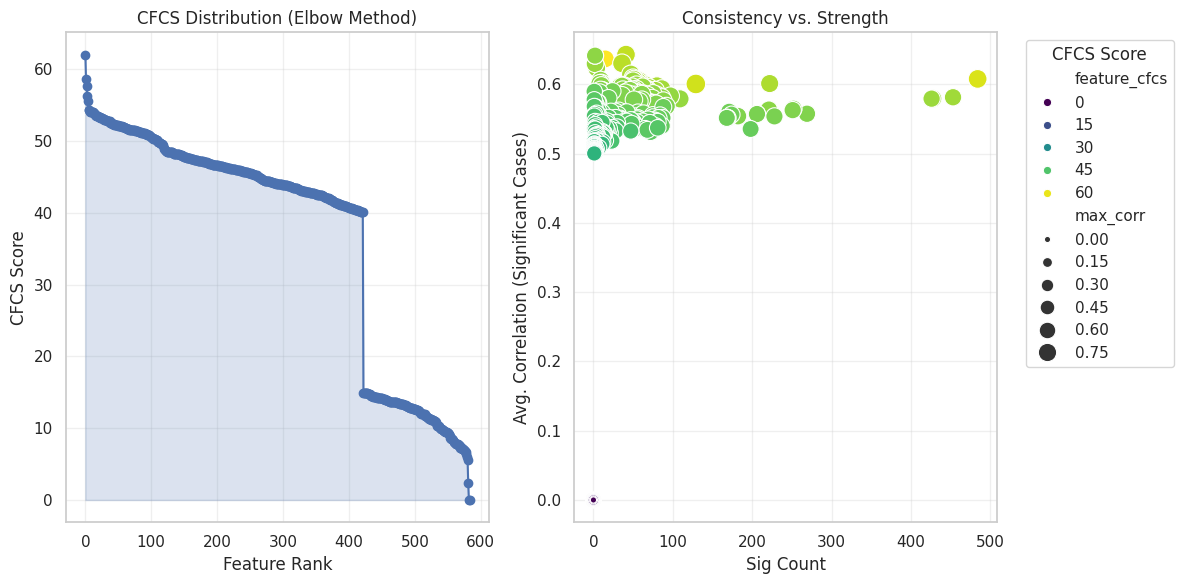

In [44]:
def plot_cfcs_analysis(df_results):
    # 1. Plot: Descending CFCS values (Elbow Method)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    df_sorted = df_results.sort_values('feature_cfcs', ascending=False).reset_index()
    plt.plot(df_sorted.index, df_sorted['feature_cfcs'], marker='o', linestyle='-', color='b')
    plt.fill_between(df_sorted.index, df_sorted['feature_cfcs'], alpha=0.2, color='b')
    
    plt.title('CFCS Distribution (Elbow Method)')
    plt.xlabel('Feature Rank')
    plt.ylabel('CFCS Score')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=df_results, 
        x='sig_count', 
        y='avg_sig_corr',
        size='max_corr', 
        hue='feature_cfcs', 
        palette='viridis', 
        sizes=(20, 200)
    )
    
    plt.title('Consistency vs. Strength')
    plt.xlabel('Sig Count')
    plt.ylabel('Avg. Correlation (Significant Cases)')
    
    # Adjust legend position to not overlap with the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='CFCS Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("feature_cfcs.png")
    print("Plot saved!")
    plt.show()

plot_cfcs_analysis(feature_analysis)

In [45]:
# Identify features to remove
low_performing_features = feature_analysis[feature_analysis['sig_count'] < MIN_SIG_COUNT]['feature'].tolist()

# Keep original cnt_locations columns (required by competition)
original_cols = [c for c in low_performing_features if 'cnt_locations' in c]
FEATURES_TO_REMOVE = [c for c in low_performing_features if c not in original_cols]

In [46]:
# Get all possible climate features we could remove
all_climate_features = [c for c in baseline_df.columns if c.startswith('climate_risk_')]

print(f"\n📊 Feature Selection Summary (Top N Strategy):")
print(f"   Total climate features: {len(all_climate_features)}")
print(f"   Features to remove: {len(FEATURES_TO_REMOVE)}")

# Create optimized dataset by removing weak features
optimized_df = baseline_df.copy()

cols_before = len([c for c in optimized_df.columns if c.startswith('climate_risk_')])
optimized_df = optimized_df.drop(columns=FEATURES_TO_REMOVE, errors='ignore')
cols_after = len([c for c in optimized_df.columns if c.startswith('climate_risk_')])

print(f"📊 Climate features: {cols_before} → {cols_after} (removed {cols_before - cols_after})")


📊 Feature Selection Summary (Top N Strategy):
   Total climate features: 584
   Features to remove: 524
📊 Climate features: 584 → 60 (removed 524)


In [47]:
print("Computing CFCS-Score:")
optimized_score = compute_cfcs(optimized_df)

print(f"🏆 CFCS: {optimized_score['cfcs']}")

Computing CFCS-Score:
CFCS: 56.09 | Sig: 7994/131070 (6.10%) | Features: 60
🏆 CFCS: 56.09


# CFCS Feature Optimization Framework

This Python script implements a comprehensive pipeline for optimizing climate risk features for the CFCS metric (Climate Feature Correlation Score).

Core Functionalities:

*   Feature Importance Analysis – Evaluates climate features based on mutual information, correlation, variance, and coverage.
*   Redundancy Pruning – Removes highly correlated features (threshold: 0.95) while ensuring protected features (e.g., climate_risk_cnt_*) are never deleted.
*   Greedy Forward Selection – Iteratively adds features that improve the CFCS score (max. 20 iterations).
*   Greedy Backward Elimination – Removes features that do not significantly impact the score, while maintaining a minimum count (20–25 features) and adhering to a tolerance threshold.
*   Evaluation & Export – Saves optimized datasets and detailed logs with timestamps.

Highlights:

*   Protection of critical features against automatic removal (e.g. climate_risk_cnt_*)
*   Expected runtime: 0.5–4 hours (depending on config)
*   Automatic validation and error handling
*   JSON export of optimization results

The framework maximizes predictive power while minimizing feature redundancy.

In [48]:
if DO_OPTIMIZATION:
    # =============================================================================
    # CFCS FEATURE OPTIMIZATION FRAMEWORK
    # =============================================================================
    # @Author: Christopher Masch
    # Version: 0.3
    #
    #
    # Strategy:
    # 1. Feature Importance Analysis
    # 2. Correlation-based Pruning
    # 3. Greedy Forward/Backward Selection
    # 4. Automated Optimization Run
    # =============================================================================
    
    import numpy as np
    import pandas as pd
    from sklearn.feature_selection import mutual_info_regression
    import warnings
    warnings.filterwarnings('ignore')
    from datetime import datetime
    import json
    
    print("="*80)
    print("🚀 Starting CFCS FEATURE OPTIMIZATION FRAMEWORK")
    print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
    # =============================================================================
    # CONFIGURATION
    # =============================================================================
    
    CONFIG = {
        'min_features': 30,
        'redundancy_threshold': 0.95,
        'max_forward_iterations': 80,
        'backward_tolerance': 0.01,
        'verbose': 0,
    }
    
    # =============================================================================
    # PROTECTED FEATURES - should not be removed
    # =============================================================================
    
    PROTECTED_FEATURE_PATTERNS = [
        'climate_risk_cnt_',
    ]
    
    def is_protected_feature(feature_name):
        """Check if feature is protected from removal"""
        for pattern in PROTECTED_FEATURE_PATTERNS:
            if feature_name.startswith(pattern):
                return True
        return False
    
    # =============================================================================
    # SETUP & VALIDATION
    # =============================================================================
    
    print("\n" + "="*80)
    print("STEP 1: Setup & Validation")
    print("="*80)
    
    # Validate optimized_df exists
    if 'optimized_df' not in locals() and 'optimized_df' not in globals():
        raise ValueError("❌ optimized_df not found! Please create it first.")
    
    # Ensure critical columns exist
    critical_columns = ['date_on', 'date_on_month', 'date_on_year', 'country_name']
    missing_critical = [c for c in critical_columns if c not in optimized_df.columns]
    
    if missing_critical:
        print(f"⚠️  Creating missing critical columns: {missing_critical}")
        
        if 'date_on_month' not in optimized_df.columns:
            optimized_df['date_on_month'] = pd.to_datetime(optimized_df['date_on']).dt.month
        
        if 'date_on_year' not in optimized_df.columns:
            optimized_df['date_on_year'] = pd.to_datetime(optimized_df['date_on']).dt.year
        
        if 'date_on_day' not in optimized_df.columns:
            optimized_df['date_on_day'] = pd.to_datetime(optimized_df['date_on']).dt.day
    
    # Define column sets
    ALL_NON_CLIMATE_COLS = [c for c in optimized_df.columns if not c.startswith('climate_risk_')]
    ALL_CLIMATE_FEATURES = [c for c in optimized_df.columns if c.startswith('climate_risk_')]
    CURRENT_CLIMATE_FEATURES = [c for c in ALL_CLIMATE_FEATURES if optimized_df[c].notna().any()]
    
    # ✅ PROTECTED FEATURES - These can NEVER be removed!
    PROTECTED_FEATURES = [f for f in ALL_CLIMATE_FEATURES if is_protected_feature(f)]
    OPTIMIZABLE_FEATURES = [f for f in CURRENT_CLIMATE_FEATURES if not is_protected_feature(f)]
    
    print(f"\n✓ Setup Complete:")
    print(f"  Total columns: {len(optimized_df.columns)}")
    print(f"  Non-climate columns: {len(ALL_NON_CLIMATE_COLS)}")
    print(f"  All climate features: {len(ALL_CLIMATE_FEATURES)}")
    print(f"  Currently used climate features: {len(CURRENT_CLIMATE_FEATURES)}")
    print(f"  🔒 PROTECTED features (NEVER removed): {len(PROTECTED_FEATURES)}")
    print(f"  🔧 OPTIMIZABLE features: {len(OPTIMIZABLE_FEATURES)}")
    print(f"  Unused climate features: {len(ALL_CLIMATE_FEATURES) - len(CURRENT_CLIMATE_FEATURES)}")
    
    if CONFIG['verbose']:
        print(f"\n  Protected feature patterns:")
        for pattern in PROTECTED_FEATURE_PATTERNS:
            count = len([f for f in PROTECTED_FEATURES if f.startswith(pattern)])
            print(f"    🔒 {pattern}*  ({count} features)")
        
        print(f"\n  Examples of protected features:")
        for feat in sorted(PROTECTED_FEATURES)[:10]:
            print(f"    🔒 {feat}")
        if len(PROTECTED_FEATURES) > 10:
            print(f"    ... and {len(PROTECTED_FEATURES) - 10} more")
    
    # Validate compute_cfcs works
    baseline_result = compute_cfcs(optimized_df)
    BASELINE_CFCS = baseline_result['cfcs']
    print(f"\n✓ Baseline CFCS: {BASELINE_CFCS}")
    
    
    # =============================================================================
    # HELPER FUNCTIONS
    # =============================================================================
    
    def build_test_df(base_df, climate_features):
        """Build test dataframe with given climate features"""
        return base_df[ALL_NON_CLIMATE_COLS + climate_features].copy()
    
    
    # =============================================================================
    # FEATURE IMPORTANCE ANALYSIS
    # =============================================================================
    
    print("\n" + "="*80)
    print("STEP 2: Feature Importance Analysis")
    print("="*80)
    
    def analyze_feature_importance(df, climate_features, target='futures_close_ZC_1'):
        """
        Compute importance metrics for each feature
        """
        print(f"Analyzing importance of {len(climate_features)} features...")
        
        analysis_df = df.dropna(subset=[target]).copy()
        results = []
        
        for i, feature in enumerate(climate_features, 1):
            if i % 10 == 0:
                print(f"Progress: {i}/{len(climate_features)}")
            
            if feature not in analysis_df.columns or analysis_df[feature].isna().all():
                continue
            
            feature_data = analysis_df[[feature, target]].dropna()
            
            if len(feature_data) < 100:
                continue
            
            # Mutual Information
            try:
                mi_score = mutual_info_regression(
                    feature_data[[feature]], 
                    feature_data[target],
                    random_state=42
                )[0]
            except:
                mi_score = 0
            
            # Correlation
            corr = abs(feature_data[feature].corr(feature_data[target]))
            
            # Variance
            variance = feature_data[feature].var()
            
            # Coverage
            coverage = 1 - analysis_df[feature].isna().mean()
            
            # Composite score
            composite = mi_score * corr * coverage
            
            results.append({
                'feature': feature,
                'mi_score': mi_score,
                'correlation': corr,
                'variance': variance,
                'coverage': coverage,
                'composite_score': composite
            })
        
        importance_df = pd.DataFrame(results).sort_values('composite_score', ascending=False)
        
        print(f"✓ Analyzed {len(importance_df)} features")
        
        if CONFIG['verbose']:
            print("\n  Top 10 by Composite Score:")
            for idx, row in importance_df.head(10).iterrows():
                print(f"    {row['feature'][:50]:50s} | {row['composite_score']:.4f}")
        
        return importance_df
    
    # Run analysis
    importance_df = analyze_feature_importance(
        optimized_df, 
        ALL_CLIMATE_FEATURES
    )
    
    # =============================================================================
    # REDUNDANCY PRUNING
    # =============================================================================
    
    print("\n" + "="*80)
    print("STEP 3: Redundancy Pruning")
    print("="*80)
    
    def remove_redundant_features(df, features, threshold=0.95):
        """
        Remove highly correlated features
        PROTECTED: Features matching PROTECTED_FEATURE_PATTERNS are never removed
        """
        print(f"Checking {len(features)} features for redundancy (threshold={threshold})...")
        
        # Separate protected and optimizable features
        protected = [f for f in features if is_protected_feature(f)]
        optimizable = [f for f in features if not is_protected_feature(f)]
        
        print(f"  Protected features: {len(protected)}")
        print(f"  Optimizable features: {len(optimizable)}")
        
        if len(optimizable) == 0:
            print("  ⚠️  No optimizable features to prune!")
            return features, []
        
        # Only check correlation among optimizable features
        feature_df = df[optimizable].dropna(how='all')
        
        if len(feature_df.columns) < 2:
            print("  ⚠️  Not enough optimizable features for correlation check")
            return features, []
        
        corr_matrix = feature_df.corr().abs()
        
        # Find highly correlated pairs
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        to_drop = set()
        
        for column in upper_triangle.columns:
            correlated = upper_triangle[column][upper_triangle[column] > threshold].index.tolist()
            
            if correlated:
                # Keep feature with higher variance
                variances = {col: feature_df[col].var() for col in [column] + correlated}
                sorted_by_var = sorted(variances.items(), key=lambda x: x[1], reverse=True)
                
                # Drop all except the one with highest variance
                for feat, _ in sorted_by_var[1:]:
                    to_drop.add(feat)
        
        # Remaining = protected features + non-redundant optimizable features
        remaining = protected + [f for f in optimizable if f not in to_drop]
        
        print(f"✓ Removed {len(to_drop)} redundant features")
        print(f"  🔒 Protected (kept): {len(protected)}")
        print(f"  🔧 Optimizable remaining: {len(remaining) - len(protected)}")
        
        if len(to_drop) > 0 and CONFIG['verbose']:
            print(f"\n  Removed features (first 10):")
            for feat in list(to_drop)[:10]:
                print(f"    - {feat}")
        
        return remaining, list(to_drop)
    
    # Apply redundancy pruning
    pruned_features, dropped_redundant = remove_redundant_features(
        optimized_df,
        CURRENT_CLIMATE_FEATURES,
        threshold=CONFIG['redundancy_threshold']
    )
    
    # Evaluate pruned set
    pruned_df = build_test_df(optimized_df, pruned_features)
    pruned_score = compute_cfcs(pruned_df)['cfcs']
    
    if pruned_score:
        print(f"After pruning: {pruned_score:.2f} CFCS (Δ {pruned_score - BASELINE_CFCS:+.3f})")
    else:
        print("⚠️  Pruned set failed CFCS computation, reverting...")
        pruned_features = CURRENT_CLIMATE_FEATURES.copy()
        pruned_score = BASELINE_CFCS
    
    # =============================================================================
    # GREEDY FORWARD SELECTION
    # =============================================================================
    
    print("\n" + "="*80)
    print("STEP 4: Greedy Forward Selection")
    print("="*80)
    
    def greedy_forward_selection(df, candidate_features, base_features, max_iterations=20):
        """
        Greedy forward selection - add features that improve CFCS
        """
        print(f"Starting forward selection with {len(candidate_features)} candidates")
        print(f"Max iterations: {max_iterations}")
        
        current_features = base_features.copy()
        current_df = build_test_df(df, current_features)
        current_score = compute_cfcs(current_df, CONFIG['verbose'])['cfcs']
        
        if not current_score:
            print("❌ Failed to compute initial CFCS")
            return base_features, []
        
        print(f"Starting CFCS: {current_score:.2f}")
        
        improvements = []
        best_score = current_score
        
        for iteration in range(max_iterations):
            print(f"\nIteration {iteration + 1}/{max_iterations}")
            
            best_feature = None
            best_iteration_score = best_score
            
            remaining = [f for f in candidate_features if f not in current_features]
            print(f"  Testing {len(remaining)} remaining candidates...")
            
            for i, feature in enumerate(remaining):
                if (i + 1) % 10 == 0:
                    print(f"    Progress: {i+1}/{len(remaining)}", end='\r')
                
                # Test feature
                test_features = current_features + [feature]
                test_df = build_test_df(df, test_features)
                score = compute_cfcs(test_df, CONFIG['verbose'])['cfcs']
                
                if score and score > best_iteration_score:
                    best_iteration_score = score
                    best_feature = feature
            
            print()  # New line after progress
            
            if best_feature is None:
                print("  No improvement found. Stopping forward selection.")
                break
            
            # Add best feature
            current_features.append(best_feature)
            improvement = best_iteration_score - best_score
            best_score = best_iteration_score
            
            improvements.append({
                'iteration': iteration + 1,
                'feature': best_feature,
                'cfcs': best_score,
                'improvement': improvement
            })
            
            print(f"  ✓ Added: {best_feature[:60]}")
            print(f"    New CFCS: {best_score:.2f} (+{improvement:.3f})")
        
        print(f"\n✓ Forward Selection Complete")
        print(f"  Final CFCS: {best_score:.2f}")
        print(f"  Total Features: {len(current_features)}")
        print(f"  Features Added: {len(improvements)}")
        print(f"  Total Improvement: +{best_score - current_score:.3f}")
        
        return current_features, improvements
    
    # Get candidates (features not in pruned set)
    forward_candidates = [f for f in ALL_CLIMATE_FEATURES if f not in pruned_features]
    
    # Run forward selection
    forward_features, forward_improvements = greedy_forward_selection(
        optimized_df,
        forward_candidates,
        pruned_features,
        max_iterations=CONFIG['max_forward_iterations']
    )
    
    # =============================================================================
    # GREEDY BACKWARD ELIMINATION
    # =============================================================================
    
    print("\n" + "="*80)
    print("STEP 5: Greedy Backward Elimination")
    print("="*80)
    
    def greedy_backward_elimination(df, current_features, min_features=40, tolerance=0.01):
        """
        Greedy backward elimination - remove features that don't hurt CFCS
        PROTECTED: Features matching PROTECTED_FEATURE_PATTERNS are never removed
        """
        print(f"Starting backward elimination")
        
        # Separate protected and optimizable features
        protected = [f for f in current_features if is_protected_feature(f)]
        optimizable = [f for f in current_features if not is_protected_feature(f)]
        
        print(f"  Total features: {len(current_features)}")
        print(f"  🔒 Protected features: {len(protected)}")
        print(f"  🔧 Optimizable features: {len(optimizable)}")
        print(f"  Min total features: {min_features}")
        print(f"  Min optimizable after removal: {max(0, min_features - len(protected))}")
        print(f"  Tolerance: {tolerance}")
        
        working_features = current_features.copy()
        baseline_df = build_test_df(df, working_features)
        baseline_score = compute_cfcs(baseline_df)['cfcs']
        
        if not baseline_score:
            print("❌ Failed to compute initial CFCS")
            return current_features, []
        
        print(f"  Baseline CFCS: {baseline_score:.2f}")
        
        removed_features = []
        best_score = baseline_score
        
        # Only remove optimizable features
        while len(working_features) > min_features:
            # Get current optimizable features
            current_optimizable = [f for f in working_features if not is_protected_feature(f)]
            
            if len(current_optimizable) == 0:
                print("  ℹ️  All remaining features are protected. Stopping.")
                break
            
            print(f"\n  Testing removal from {len(current_optimizable)} optimizable features...")
            
            current_protected = len([f for f in working_features if is_protected_feature(f)])
            print(f"    (Total: {len(working_features)}, Protected: {current_protected})")
            
            worst_feature = None
            best_removal_score = best_score
            
            for i, feature in enumerate(current_optimizable):
                if (i + 1) % 10 == 0:
                    print(f"    Progress: {i+1}/{len(current_optimizable)}", end='\r')
                
                # Test without this feature
                test_features = [f for f in working_features if f != feature]
                test_df = build_test_df(df, test_features)
                score = compute_cfcs(test_df, CONFIG['verbose'])['cfcs']
                
                # If score doesn't drop (within tolerance)
                if score and score >= best_score - tolerance:
                    if score > best_removal_score or worst_feature is None:
                        best_removal_score = score
                        worst_feature = feature
            
            print()  # New line
            
            if worst_feature is None:
                print("  ℹ️  No safe removal found. Stopping.")
                break
            
            # Remove feature
            working_features.remove(worst_feature)
            removed_features.append(worst_feature)
            improvement = best_removal_score - best_score
            best_score = best_removal_score
            
            print(f"  ✓ Removed: {worst_feature[:60]}")
            print(f"    New CFCS: {best_score:.2f} ({improvement:+.3f})")
        
        final_protected = len([f for f in working_features if is_protected_feature(f)])
        final_optimizable = len([f for f in working_features if not is_protected_feature(f)])
        
        print(f"\n✓ Backward Elimination Complete")
        print(f"  Final CFCS: {best_score:.2f}")
        print(f"  Total Features: {len(working_features)}")
        print(f"  🔒 Protected Features: {final_protected}")
        print(f"  🔧 Optimizable Features: {final_optimizable}")
        print(f"  Removed: {len(removed_features)} features")
        
        # Verify no protected features were removed
        removed_protected = [f for f in removed_features if is_protected_feature(f)]
        if removed_protected:
            print(f"  ⚠️  WARNING: {len(removed_protected)} protected features were removed!")
            for feat in removed_protected:
                print(f"    - {feat}")
        
        return working_features, removed_features
    
    # Run backward elimination
    final_features, backward_removed = greedy_backward_elimination(
        optimized_df,
        forward_features,
        min_features=CONFIG['min_features'],
        tolerance=CONFIG['backward_tolerance']
    )
    
    # =============================================================================
    # FINAL EVALUATION & SAVE
    # =============================================================================
    
    print("\n" + "="*80)
    print("STEP 6: Final Evaluation & Save")
    print("="*80)
    
    # Build final dataframe
    final_df = build_test_df(optimized_df, final_features)
    final_result = compute_cfcs(final_df, CONFIG['verbose'])
    final_score = final_result['cfcs']
    
    # Results summary
    final_protected_count = len([f for f in final_features if is_protected_feature(f)])
    final_optimizable_count = len([f for f in final_features if not is_protected_feature(f)])
    
    results = {
        'timestamp': datetime.now().isoformat(),
        'baseline_cfcs': BASELINE_CFCS,
        'after_pruning_cfcs': pruned_score,
        'after_forward_cfcs': forward_improvements[-1]['cfcs'] if forward_improvements else pruned_score,
        'final_cfcs': final_score,
        'total_improvement': final_score - BASELINE_CFCS,
        'baseline_features': len(CURRENT_CLIMATE_FEATURES),
        'final_features': len(final_features),
        'final_protected_features': final_protected_count,
        'final_optimizable_features': final_optimizable_count,
        'features_removed_redundancy': len(dropped_redundant),
        'features_added_forward': len(forward_improvements),
        'features_removed_backward': len(backward_removed),
        'protected_feature_patterns': PROTECTED_FEATURE_PATTERNS,
        'protected_features_list': [f for f in final_features if is_protected_feature(f)],
        'optimizable_features_list': [f for f in final_features if not is_protected_feature(f)],
        'feature_list': final_features,
    }
    
    # Count protected features in final set
    final_protected = len([f for f in final_features if is_protected_feature(f)])
    final_optimizable = len([f for f in final_features if not is_protected_feature(f)])
    
    print(f"""
    Baseline CFCS:    {BASELINE_CFCS:.2f}
    After Pruning:    {pruned_score:.2f} ({pruned_score - BASELINE_CFCS:+.3f})
    After Forward:    {results['after_forward_cfcs']:.2f} ({results['after_forward_cfcs'] - BASELINE_CFCS:+.3f})
    Final CFCS:       {final_score:.2f} ({final_score - BASELINE_CFCS:+.3f})
    
    Total Improvement: {final_score - BASELINE_CFCS:+.3f}
    
    Features:
      Baseline:         {len(CURRENT_CLIMATE_FEATURES)}
      Final:            {len(final_features)}
        🔒 Protected:   {final_protected} (NEVER removed)
        🔧 Optimizable: {final_optimizable}
      Removed (pruning):{len(dropped_redundant)}
      Added (forward):  {len(forward_improvements)}
      Removed (backward):{len(backward_removed)}
    
    Significant Correlations: {final_result['sig_count']}/{final_result['total']} ({final_result['sig_pct']:.2f}%)
    """)
    
    # Save final submission
    final_df_clean = final_df.dropna(axis=1, how='any')
    output_file = f'submission_optimized_{datetime.now().strftime("%Y%m%d_%H%M")}.csv'
    final_df_clean.to_csv(output_file, index=False)
    
    print(f"  Saved: {output_file}")
    print(f"  Rows: {len(final_df_clean):,}")
    print(f"  Columns: {len(final_df_clean.columns)}")
    
    # Save optimization log
    log_file = f'optimization_log_{datetime.now().strftime("%Y%m%d_%H%M")}.json'
    with open(log_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"  Saved log: {log_file}")
    
    # Print top features added
    if forward_improvements:
        print("\n📊 Top Features Added (Forward Selection):")
        for imp in forward_improvements[:10]:
            print(f"  {imp['iteration']:2d}. {imp['feature'][:60]:60s} +{imp['improvement']:.3f}")
    
    # Print features removed
    if backward_removed:
        print(f"\n🗑️  Features Removed (Backward Elimination): {len(backward_removed)}")
        for feat in backward_removed[:10]:
            print(f"  - {feat}")
    
    print("\n" + "="*80)
    print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    print("\n✅ OPTIMIZATION PIPELINE COMPLETE!")
    print(f"🎯 Final Score: {final_score:.2f}")
    print(f"📁 Saved to: {output_file}")

# Save Submission

In [49]:
# Define final Feature-Liste w/o external data
feature_list = [
    "climate_risk_cnt_locations_heat_stress_risk_low",
    "climate_risk_cnt_locations_heat_stress_risk_medium",
    "climate_risk_cnt_locations_heat_stress_risk_high",
    "climate_risk_cnt_locations_unseasonably_cold_risk_low",
    "climate_risk_cnt_locations_unseasonably_cold_risk_medium",
    "climate_risk_cnt_locations_unseasonably_cold_risk_high",
    "climate_risk_cnt_locations_excess_precip_risk_low",
    "climate_risk_cnt_locations_excess_precip_risk_medium",
    "climate_risk_cnt_locations_excess_precip_risk_high",
    "climate_risk_cnt_locations_drought_risk_low",
    "climate_risk_cnt_locations_drought_risk_medium",
    "climate_risk_cnt_locations_drought_risk_high",
    "climate_risk_excess_precip_ma_60d",
    "climate_risk_drought_ma_60d",
    "climate_risk_drought_ma_90d",
    "climate_risk_excess_precip_ma_90d",
    "climate_risk_drought_ma_180d",
    "climate_risk_drought_ma_270d",
    "climate_risk_drought_ma_320d",
    "climate_risk_drought_ma_365d",
    "climate_risk_drought_ma_400d",
    "climate_risk_drought_ema_90d",
    "climate_risk_excess_precip_ema_180d",
    "climate_risk_drought_ema_180d",
    "climate_risk_excess_precip_ema_270d",
    "climate_risk_drought_ema_270d",
    "climate_risk_drought_ema_320d",
    "climate_risk_drought_ema_365d",
    "climate_risk_drought_ema_400d",
    "climate_risk_drought_stress_days_45d",
    "climate_risk_drought_stress_days_75d",
    "climate_risk_drought_stress_days_120d",
    "climate_risk_drought_stress_days_180d",
    "climate_risk_drought_stress_days_270d",
    "climate_risk_drought_stress_days_320d",
    "climate_risk_drought_stress_days_365d",
    "climate_risk_drought_stress_days_400d",
    "climate_risk_drought_ma_x_ema_365d",
    "climate_risk_drought_ma_x_ema_270d",
    "climate_risk_drought_ma_x_ema_180d",
    "climate_risk_drought_ma_x_ema_90d",
    "climate_risk_drought_ma_x_ema_365d_log",
    "climate_risk_drought_ma_x_ema_365d_sqrt",
    "climate_risk_drought_ma_x_ema_270d_log",
    "climate_risk_drought_ma_x_ema_270d_sqrt",
    "climate_risk_drought_ma_x_ema_180d_log",
    "climate_risk_drought_ma_x_ema_180d_sqrt",
    "climate_risk_precip_ma_x_ema_180d_sqrt",
    "climate_risk_drought_ma_x_ema_90d_log",
    "climate_risk_drought_ma_x_ema_90d_sqrt",
    "climate_risk_precip_ma_x_ema_90d_sqrt",
    "climate_risk_drought_ma_90d_new_log",
    "climate_risk_drought_ma_90d_new_sqrt",
    "climate_risk_drought_ma_90d_new_squared",
    "climate_risk_drought_ema_90d_new_log",
    "climate_risk_drought_ema_90d_new_sqrt",
    "climate_risk_drought_ma_180d_new_log",
    "climate_risk_drought_ma_180d_new_sqrt",
    "climate_risk_drought_ma_180d_new_squared",
    "climate_risk_drought_ema_180d_new_log",
    "climate_risk_drought_ema_180d_new_sqrt",
    "climate_risk_drought_ema_180d_new_squared",
    "climate_risk_drought_ma_270d_new_log",
    "climate_risk_drought_ma_270d_new_sqrt",
    "climate_risk_drought_ma_270d_new_squared",
    "climate_risk_drought_ema_270d_new_log",
    "climate_risk_drought_ema_270d_new_sqrt",
    "climate_risk_drought_ema_270d_new_squared",
    "climate_risk_excess_precip_ma_90d_new_log",
    "climate_risk_excess_precip_ma_90d_new_sqrt",
    "climate_risk_excess_precip_ema_90d_new_sqrt",
    "climate_risk_excess_precip_ma_180d_new_log",
    "climate_risk_excess_precip_ma_180d_new_sqrt",
    "climate_risk_excess_precip_ema_180d_new_log",
    "climate_risk_excess_precip_ema_180d_new_sqrt",
    "climate_risk_excess_precip_ma_270d_new_log",
    "climate_risk_excess_precip_ma_270d_new_sqrt",
    "climate_risk_excess_precip_ema_270d_new_log",
    "climate_risk_excess_precip_ema_270d_new_sqrt",
    "climate_risk_excess_precip_volatility_180d",
    "climate_risk_drought_cv_180d",
    "climate_risk_drought_cv_270d",
    "climate_risk_gdd_deficit"
]

# Define Feature List with external Data x Helios
if USE_EXTERNAL_DATA:
    feature_list = [
    "climate_risk_cnt_locations_heat_stress_risk_low",
    "climate_risk_cnt_locations_heat_stress_risk_medium",
    "climate_risk_cnt_locations_heat_stress_risk_high",
    "climate_risk_cnt_locations_unseasonably_cold_risk_low",
    "climate_risk_cnt_locations_unseasonably_cold_risk_medium",
    "climate_risk_cnt_locations_unseasonably_cold_risk_high",
    "climate_risk_cnt_locations_excess_precip_risk_low",
    "climate_risk_cnt_locations_excess_precip_risk_medium",
    "climate_risk_cnt_locations_excess_precip_risk_high",
    "climate_risk_cnt_locations_drought_risk_low",
    "climate_risk_cnt_locations_drought_risk_medium",
    "climate_risk_cnt_locations_drought_risk_high",
    "climate_risk_meteo_gdd_deficit_regional_zscore",
    "climate_risk_vix_x_drought_ma90",
    "climate_risk_gdd_deficit_x_vix",
    "climate_risk_stress_x_oil",
    "climate_risk_meteo_gdd_cumsum_regional_rank",
    "climate_risk_meteo_gdd_cumsum_season_zscore",
    "climate_risk_meteo_gdd_cumsum_season_pct_max"
  ]

# Base-Columns
base_columns = [
    'ID', 'crop_name', 'country_name', 'country_code', 
    'region_name', 'region_id', 'harvest_period', 
    'growing_season_year', 'date_on', 'date_on_month'
]

# Filter cols: base + feature-list + futures_*
optimized_df = optimized_df[[
    col for col in optimized_df.columns 
    if col in base_columns 
    or col in feature_list 
    or col.startswith('futures_')
]]

cols_after = len([c for c in optimized_df.columns if c.startswith('climate_risk_')])
print(cols_after)

# Check cols
for col in optimized_df.columns:
    print(col)

19
ID
crop_name
country_name
country_code
region_name
region_id
harvest_period
growing_season_year
date_on
climate_risk_cnt_locations_heat_stress_risk_low
climate_risk_cnt_locations_heat_stress_risk_medium
climate_risk_cnt_locations_heat_stress_risk_high
climate_risk_cnt_locations_unseasonably_cold_risk_low
climate_risk_cnt_locations_unseasonably_cold_risk_medium
climate_risk_cnt_locations_unseasonably_cold_risk_high
climate_risk_cnt_locations_excess_precip_risk_low
climate_risk_cnt_locations_excess_precip_risk_medium
climate_risk_cnt_locations_excess_precip_risk_high
climate_risk_cnt_locations_drought_risk_low
climate_risk_cnt_locations_drought_risk_medium
climate_risk_cnt_locations_drought_risk_high
futures_close_ZC_1
futures_close_ZC_2
futures_close_ZW_1
futures_close_ZS_1
futures_zc1_ret_pct
futures_zc1_ret_log
futures_zc_term_spread
futures_zc_term_ratio
futures_zc1_ma_20
futures_zc1_ma_60
futures_zc1_ma_120
futures_zc1_vol_20
futures_zc1_vol_60
futures_zw_zc_spread
futures_zc_zw_

In [50]:
print("Computing CFCS-Score:")
optimized_score = compute_cfcs(optimized_df)

print(f"""
🏆 CFCS: {optimized_score['cfcs']}
🏆 avg_sig_corr: {optimized_score['avg_sig_corr']}
🏆 sig_count: {optimized_score['sig_count']}
""")

Computing CFCS-Score:
CFCS: 57.15 | Sig: 2570/39134 (6.57%) | Features: 19

🏆 CFCS: 57.15
🏆 avg_sig_corr: 0.5882
🏆 sig_count: 2570



In [51]:
# Delete cols with nan values, otherwise submission will fail
#optimized_df = optimized_df.dropna(axis=1, how='any')

# Save submission
output_file = 'submission.csv'
optimized_df.to_csv(output_file, index=False)
climate_features = [c for c in optimized_df.columns if c.startswith('climate_risk_')]

print(f"Saved: {output_file}")
print(f"CFCS: {optimized_score['cfcs']}")
print(f"Rows: {len(optimized_df):,}")
print(f"Climate features: {len(climate_features)}")
print(f"Significant correlations: {optimized_score['sig_count']}/{optimized_score['total']} ({optimized_score['sig_pct']:.2f}%)")

Saved: submission.csv
CFCS: 57.15
Rows: 219,161
Climate features: 19
Significant correlations: 2570/39134 (6.57%)
